# Analisis datos House Pricing Kaggle

In [2]:
#Importando librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew, probplot
from scipy.special import boxcox1p
#lowess en  sns.residplot
import statsmodels.api as sm
#categoria a numero
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#Analisis mutual information
from sklearn.feature_selection import mutual_info_regression
#config general
pd.set_option('display.max_columns',0)
sns.set_theme(style="darkgrid")
#importando las carpetas del proyecto al path
from sys import path
import os
path.append(os.path.realpath('../'))

c:\Users\djm98\OneDrive\Escritorio\house_price_kaggle\.venv\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [3]:
#Leyendo dataframes
df_train = pd.read_csv("../datos/train.csv")

In [4]:
#Analisis inicial
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
df_train.head()

Id  MSSubClass MSZoning  ...  SaleType  SaleCondition SalePrice
0   1          60       RL  ...        WD         Normal    208500
1   2          20       RL  ...        WD         Normal    181500
2   3          60       RL  ...        WD         Normal    223500
3   4          70       RL  ...        WD        Abnorml    140000
4   5          60       RL  ...        WD         Normal    250000

[5 rows x 81 columns]

In [6]:
num_vars = df_train.columns[df_train.dtypes != 'object']
obj_vars = df_train.columns[df_train.dtypes == 'object']

print('\nNumerical vars: ')
print(num_vars.values)
print('\nObject vars: ')
print(obj_vars.values)


Numerical vars: 
['Id' 'MSSubClass' 'LotFrontage' 'LotArea' 'OverallQual' 'OverallCond'
 'YearBuilt' 'YearRemodAdd' 'MasVnrArea' 'BsmtFinSF1' 'BsmtFinSF2'
 'BsmtUnfSF' 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF' 'LowQualFinSF'
 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath' 'FullBath' 'HalfBath'
 'BedroomAbvGr' 'KitchenAbvGr' 'TotRmsAbvGrd' 'Fireplaces' 'GarageYrBlt'
 'GarageCars' 'GarageArea' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch'
 '3SsnPorch' 'ScreenPorch' 'PoolArea' 'MiscVal' 'MoSold' 'YrSold'
 'SalePrice']

Object vars: 
['MSZoning' 'Street' 'Alley' 'LotShape' 'LandContour' 'Utilities'
 'LotConfig' 'LandSlope' 'Neighborhood' 'Condition1' 'Condition2'
 'BldgType' 'HouseStyle' 'RoofStyle' 'RoofMatl' 'Exterior1st'
 'Exterior2nd' 'MasVnrType' 'ExterQual' 'ExterCond' 'Foundation'
 'BsmtQual' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2'
 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' 'KitchenQual'
 'Functional' 'FireplaceQu' 'GarageType' 'GarageFinish' 'GarageQual'
 'GarageCond' 'Pav

In [7]:
#Corrigiendo el tipo de los datos mal clasificados
df_train['MSSubClass'].astype('object')
df_train['OverallQual'].astype('object')
df_train['OverallCond'].astype('object')
df_train['YearBuilt'].astype('object')
df_train['YearRemodAdd'].astype('object')


0       2003
1       1976
2       2002
3       1970
4       2000
        ... 
1455    2000
1456    1988
1457    2006
1458    1996
1459    1965
Name: YearRemodAdd, Length: 1460, dtype: object

#### valores nulos

In [8]:
def count_null(df):
    """
    in: df <dataframe>
    out: <dataframe>
    Retorna un DF con el numero de valores nulos, el porcentaje de valores nulos y el tipo de la columna, para las columnas con al menos un valor nulo del df original
    """
    count_null = df.isnull().sum()
    porcen_null = count_null*100/df.shape[0]
    df_desc_nulos = pd.concat([count_null,porcen_null,df.dtypes],axis=1,keys= ["Count","Porcentaje","Type"])
    df_desc_nulos = df_desc_nulos[df_desc_nulos['Count']>0]
    df_desc_nulos.sort_values('Porcentaje',ascending=False,inplace=True)
    return np.transpose(df_desc_nulos)

In [9]:
count_null(df_train)

PoolQC MiscFeature      Alley  ... MasVnrArea MasVnrType Electrical
Count            1453        1406       1369  ...          8          8          1
Porcentaje  99.520548    96.30137  93.767123  ...   0.547945   0.547945   0.068493
Type           object      object     object  ...    float64     object     object

[3 rows x 19 columns]

##### Heatmap valores nulos

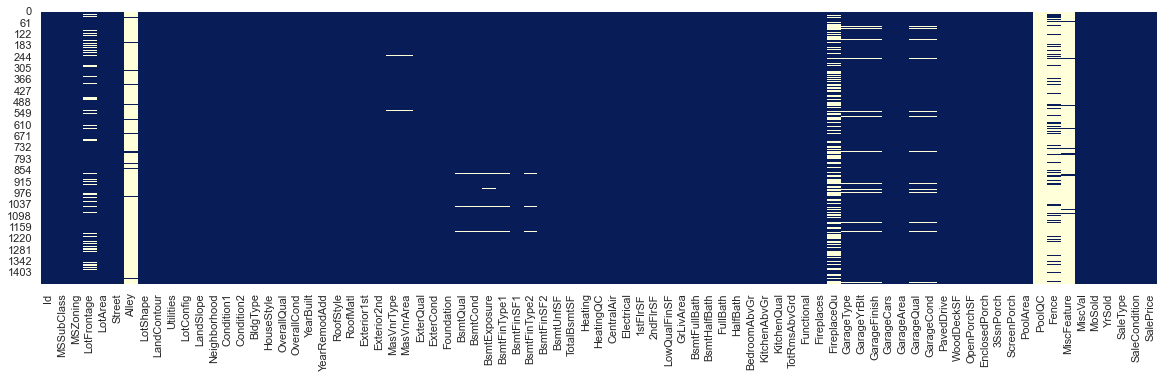

In [10]:
fig,ax = plt.subplots(figsize=(20,5))
sns.heatmap(df_train.isnull(), cbar=False, cmap='YlGnBu_r')
plt.show()

Los datos de las variables Garage_x faltan para las mismas muestras, podria significar que la casa no tiene garaje

Los datos de las variables Bsmt_x faltan para las mismas muestras, podria significar que la casa no tiene sotano

Los datos faltantes estan distribuidos equitativamente

#### analisis variable objetivo - salesprice

In [11]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Figure size 1080x360 with 0 Axes>

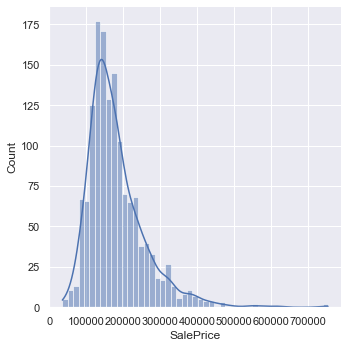

In [12]:
f = plt.figure(facecolor='whitesmoke', figsize=(15, 5))
#ax_right1 = f.add_axes([0,0,.4,.9], facecolor='whitesmoke')
#sns.displot(data=df_train,x='SalePrice',kde=True,ax=ax_right1)
sns.displot(data=df_train,x='SalePrice',kde=True)
#ax_right2 = f.add_axes([.57,0,.3,.8], facecolor='whitesmoke')
#probplot(df_train['SalePrice'],plot=ax_right2)

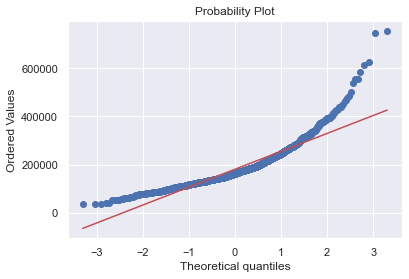

In [13]:
probplot(df_train['SalePrice'],plot=plt)
plt.show()

In [14]:
#El skew nos mide la falta de simetria en la distribucion
#0 es una distribucion sin sesgo
#un valor positivo indica sesgo hacia la izquierda, la cola de la distribucion va hacia los valores positivos (ESTAS SON MAS COMUNES)
print('La variable objetivo tiene la siguiente skew', df_train['SalePrice'].skew())
#La kurtosis mide la forma de campana de la distribucion
#0 es una distribucion con forma de campana
#un valor positivo indica que hay un pico alargado 
print('La variable objetivo tiene la siguiente kurt', df_train['SalePrice'].kurt())

La variable objetivo tiene la siguiente skew 1.8828757597682129
La variable objetivo tiene la siguiente kurt 6.536281860064529


##### ANALISIS INFORMACION MUTUA


aun faltaria definir como manejar los valores nulos de los datos numericos

In [15]:
def fill_missing_cat_columns(data,categorical):
    for c in categorical:
        data[c]=data[c].astype('category')
        if data[c].isnull().any():
            data[c]=data[c].cat.add_categories(['MISSING'])
            data[c]=data[c].fillna('MISSING')

X = df_train.copy()
y = X.pop("SalePrice")
categorical = X.select_dtypes("object")
X.drop(columns=['LotFrontage','MasVnrArea','GarageYrBlt'],inplace=True)
fill_missing_cat_columns(X,categorical)
# Label encoding for categoricals
for colname in categorical:
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y)#, discrete_features=discrete_features
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]
#mi_scores[::3]  # show a few features with their MI scores
#mi_scores[:23]
#X.columns[X.isna().any()].tolist()


OverallQual      0.508545
BsmtQual         0.329973
GarageArea       0.281112
TotalBsmtSF      0.257939
YearRemodAdd     0.199317
Fireplaces       0.172282
MSZoning         0.121390
FireplaceQu      0.104687
HalfBath         0.089053
LotArea          0.081699
SaleCondition    0.075897
BedroomAbvGr     0.069060
OpenPorchSF      0.063131
HouseStyle       0.051193
BsmtCond         0.043934
BsmtExposure     0.040567
LandContour      0.030253
ScreenPorch      0.024781
Heating          0.019434
YrSold           0.015860
LotConfig        0.012244
Utilities        0.007970
Functional       0.004382
3SsnPorch        0.000000
BsmtFinSF2       0.000000
MoSold           0.000000
Name: MI Scores, dtype: float64

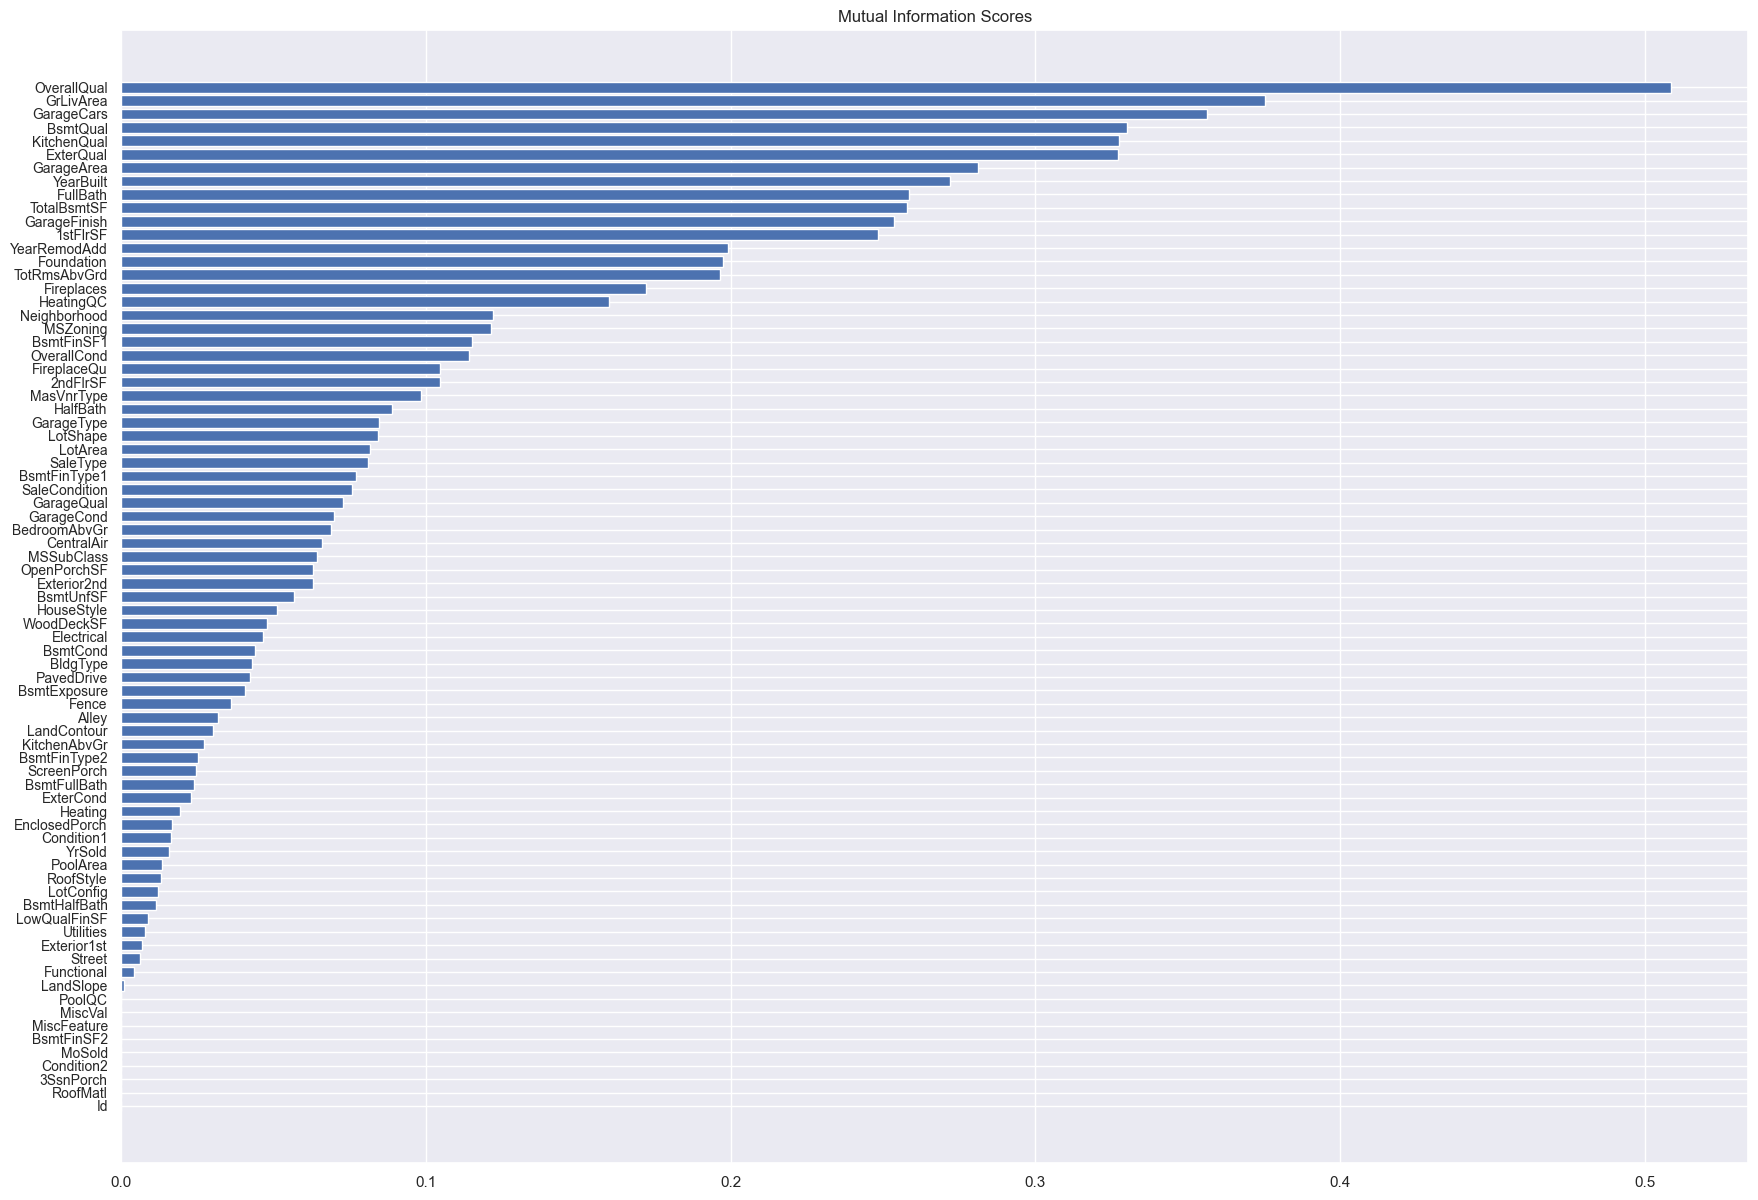

In [16]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks,fontsize=10)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(21, 15))
plot_mi_scores(mi_scores)



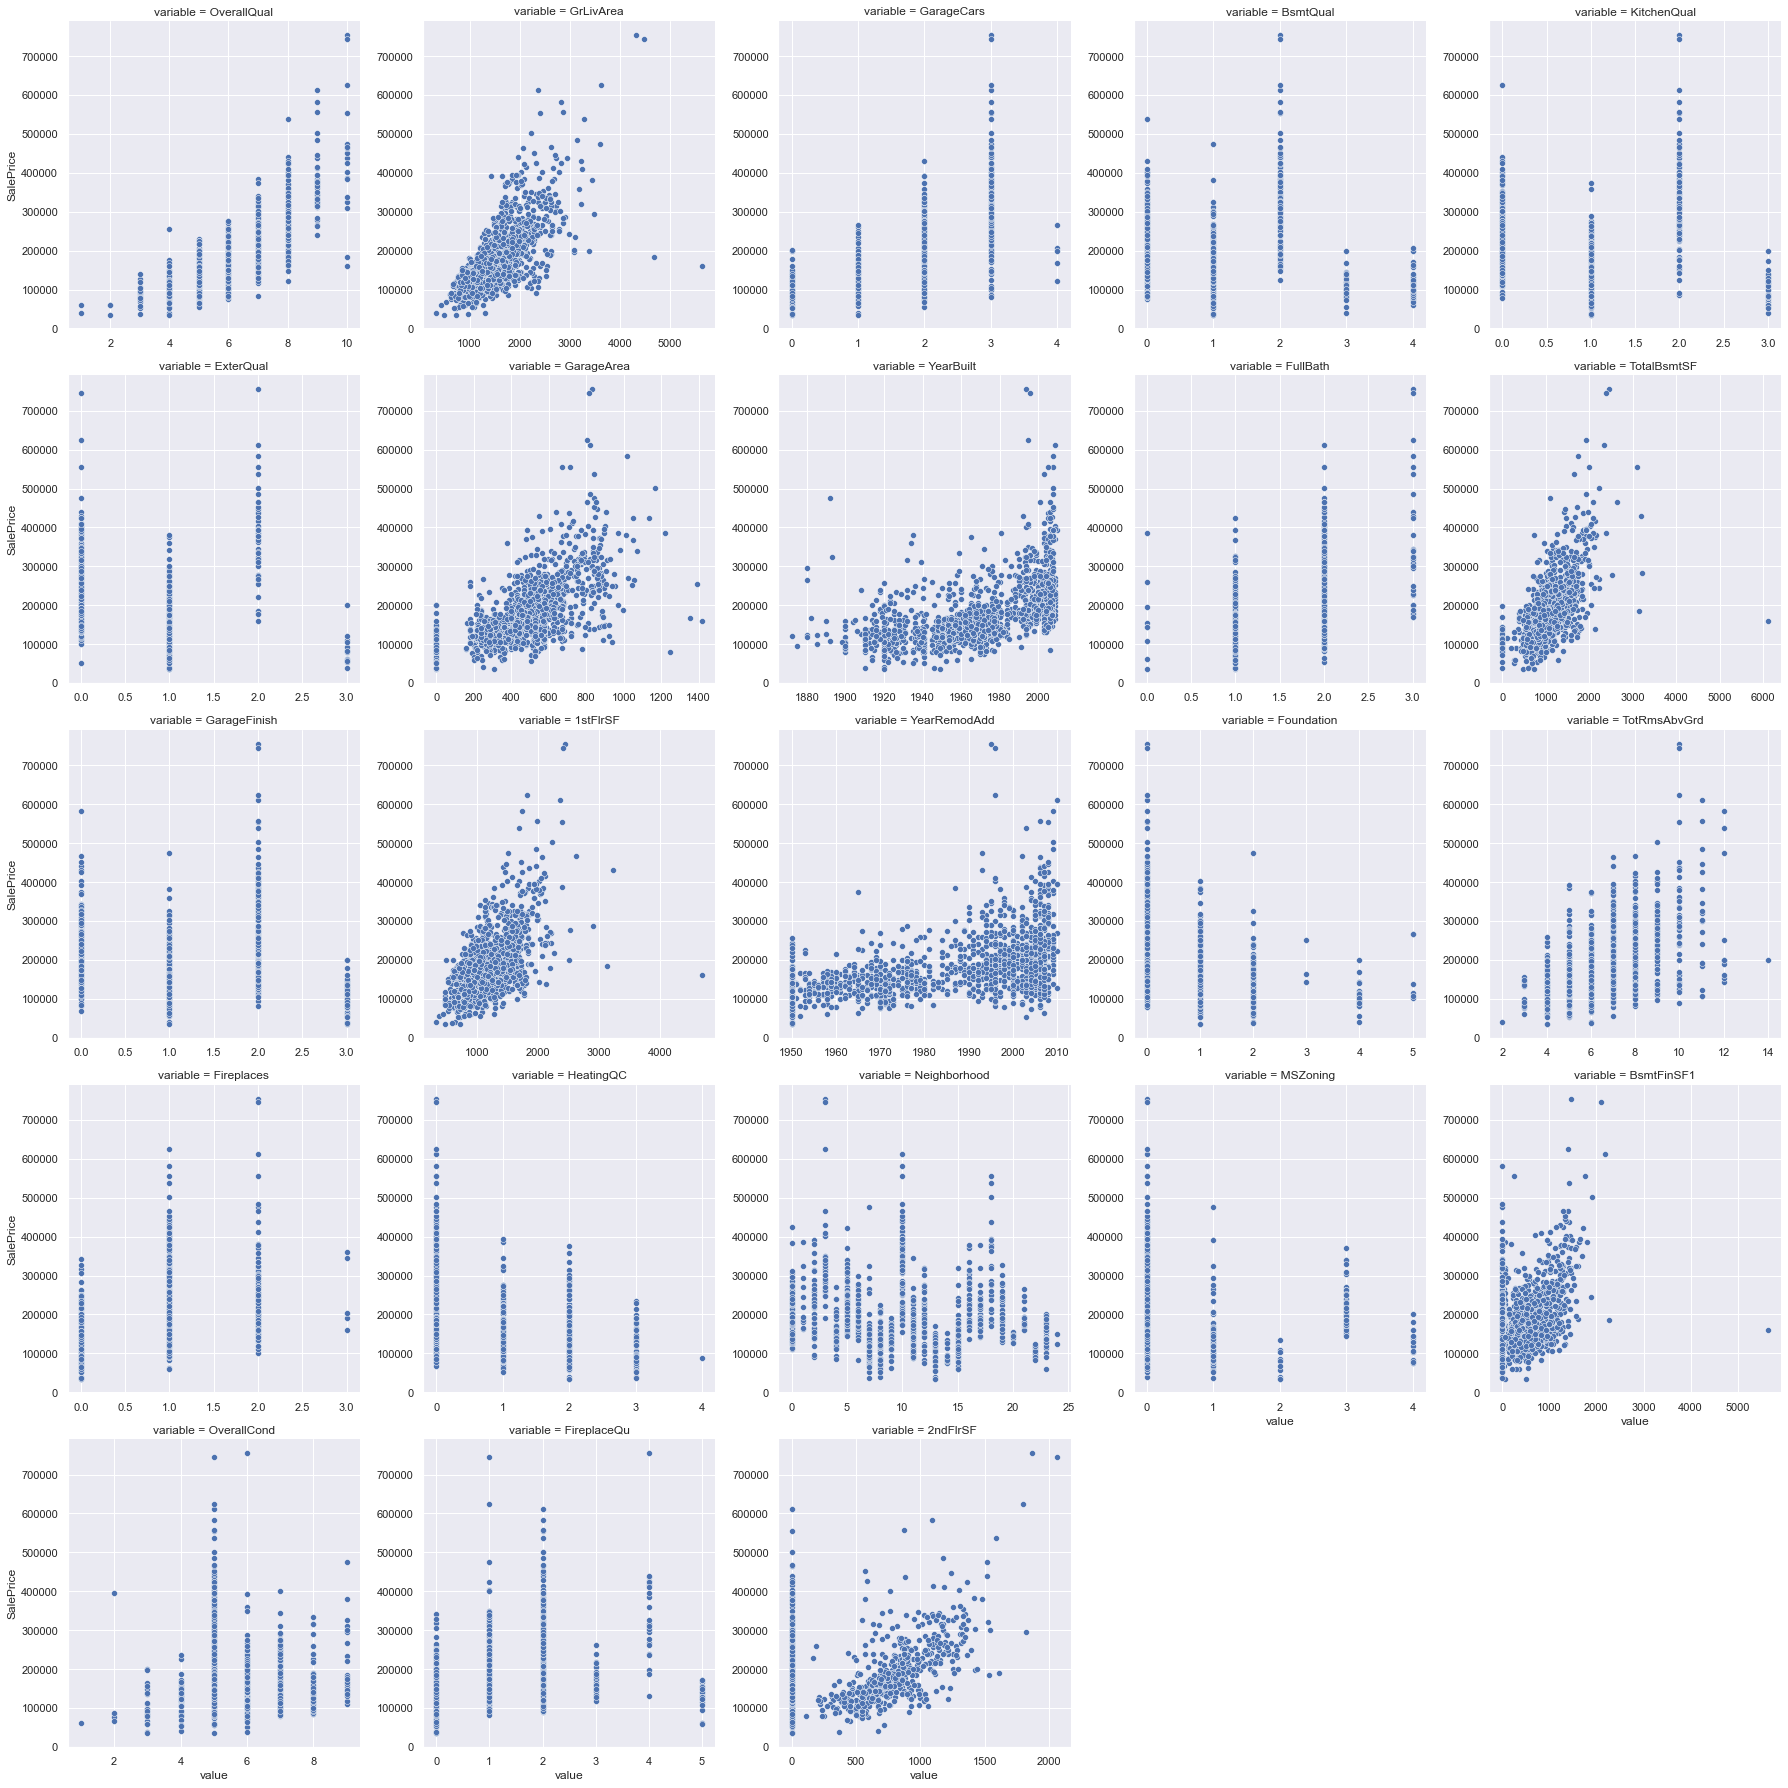

In [17]:
#Graficar mi_score
z=pd.concat([X,y],axis=1)
f = pd.melt(z,id_vars='SalePrice',value_vars=mi_scores[:23].index)
g = sns.FacetGrid(f,col='variable', col_wrap= 5, sharex= False, sharey= False,height=5)
g = g.map(sns.scatterplot,'value','SalePrice')

##### Buscando multicolinealidad

In [18]:
def zoomed_corr_heatmap(df,feature_count,target,fig_size=(12,9)):
    """
    input: 
    df <dataframe> con las variables tanto dependientes como independientes
    feature_count <integer> numero de variables a graficar, incluyendo la variable objetivo, se grafican las que presentan mayor correlacion
    target <string> variable dependiente
    fig_size <tuple> tamaño de la figura
    ouput:
    Heatmap del dataframe ingresado
    desc:
    Esta funcion recibe una dataframe, una variable objetivo y un numero de variables para luego devuelve graficar el heatmap  
    """
    corr_mat = abs(df.corr())
    cols = corr_mat.nlargest(feature_count,target)[target].index
    f,ax = plt.subplots(figsize=fig_size)
    cm = np.corrcoef(df[cols].values.T)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, cbar=True,annot=True,square=True, fmt='.2f',annot_kws={'size':10},yticklabels=cols.values, xticklabels=cols.values)
    plt.show()

In [19]:
df_train_mi = df_train[mi_scores[:23].index]
df_train_mi['SalePrice'] = df_train['SalePrice'].values

C:\Users\djm98\AppData\Local\Temp\ipykernel_15328\1801444862.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_mi['SalePrice'] = df_train['SalePrice'].values


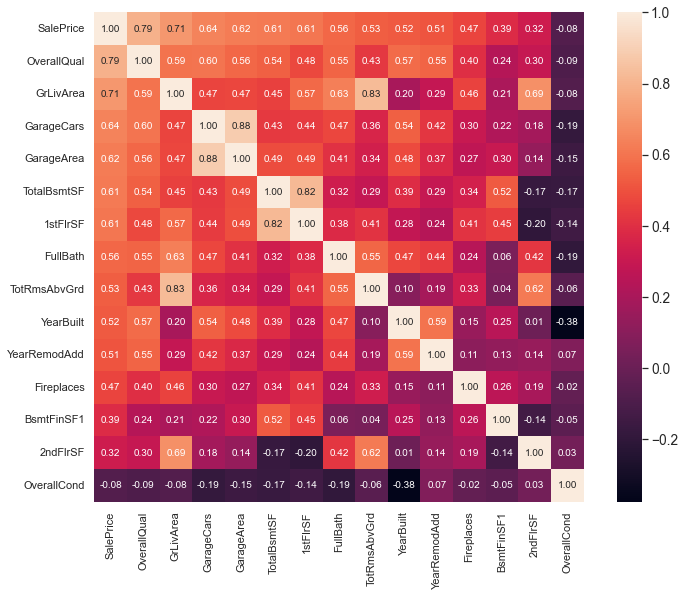

In [20]:
zoomed_corr_heatmap(df_train_mi,24,'SalePrice')

Algunas variables que presentan multicolinealidad son:

GrLivArea, TotRMsAbvGrd y 2ndFlrSF

GarageCars y GarageArea

TotalBsmtSF y 1stFlrSF 

#### Analisis variables MI

In [21]:
def test_var_cat(feature,target,rank=False):
    """
    input:
    feature <serie> variable independiente a graficar, debe ser categorica
    target <serie> variable dependinete a graficar
    output:
    grafica con boxplot,residual plot, histplot y probplot de las variables ingresadas
    desc:
    Esta funcion realiza un pequeño resumen de la relacion entre una variable dependiente y una independiente, la variable debe ser categorica
    """
    f,ax= plt.subplots(1,4,figsize=(30,8))
    sns.boxplot(x=feature,y=target,ax=ax[0])
    sns.histplot(x=feature,ax=ax[2],kde=True)
    if rank:
        sns.residplot(x=feature,y=target,ax=ax[1],lowess=True)
        probplot(feature,plot=ax[3])
    f.suptitle(f'{feature.name}',weight='bold',size=20)
    f.tight_layout()
    plt.show()

In [22]:
def test_var_con(feature,target):
    """
    input:
    feature <serie> variable independiente a graficar, debe ser numerica
    target <serie> variable dependinete a graficar
    output:
    grafica con regplot,residual plot, histplot y probplot de las variables ingresadas
    desc:
    Esta funcion realiza un pequeño resumen de la relacion entre una variable dependiente y una independiente, la variable debe ser numerica
    """
    f,ax=plt.subplots(1,4,figsize=(30,8))
    sns.regplot(x=feature,y=target,ax=ax[0])
    # sns.regplot(x=x,y=y,ax=ax[1],robust=True)
    sns.residplot(x=feature,y=target,ax=ax[1],lowess=True)
    sns.histplot(x=feature,ax=ax[2],kde=True)
    probplot(feature,plot=ax[3])
    f.suptitle(f'{feature.name}',weight='bold',size=20)
    f.tight_layout()


##### GarageCars

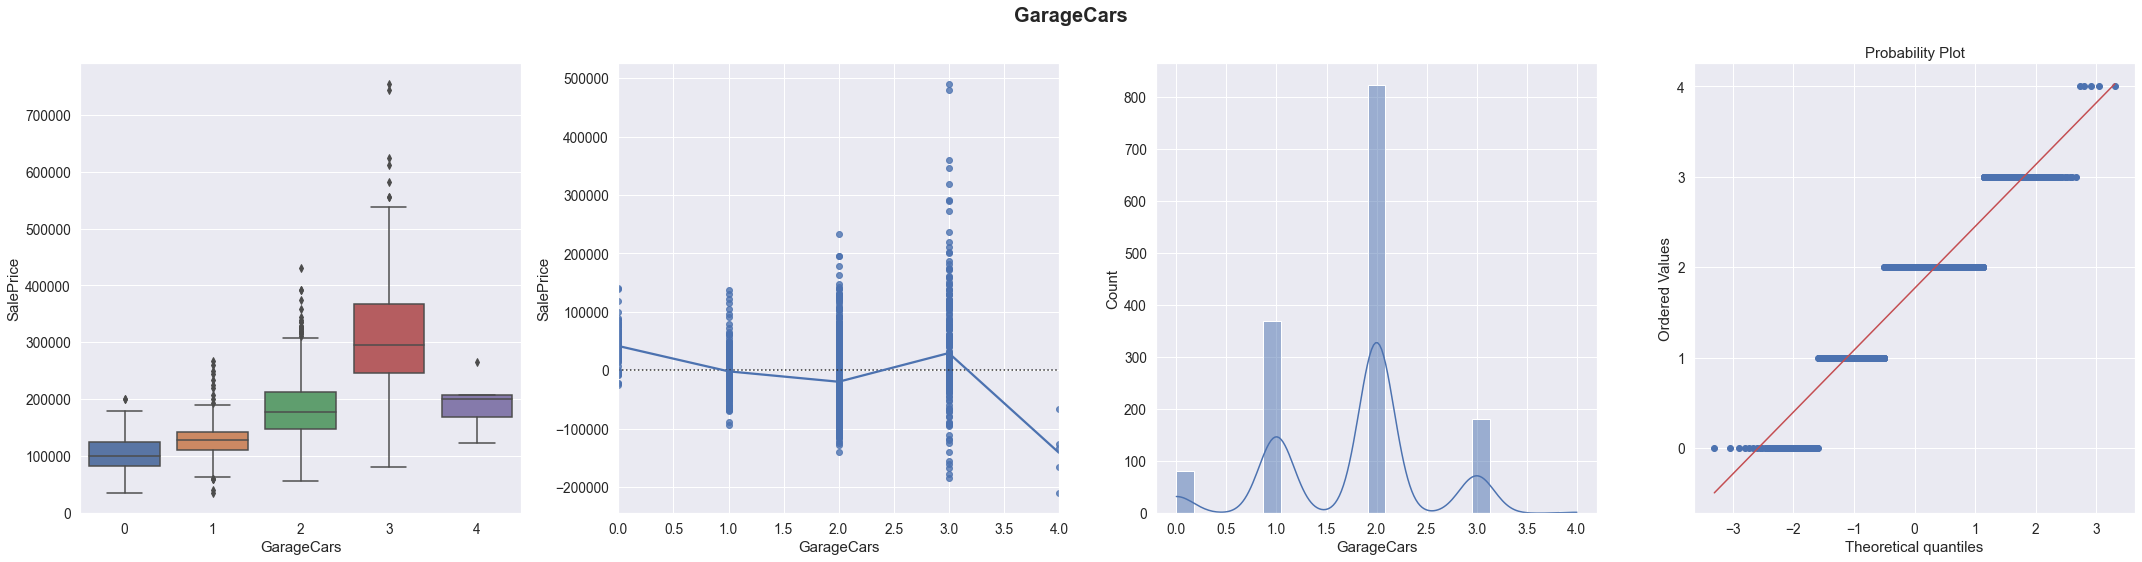

In [23]:
test_var_cat(df_train['GarageCars'],df_train['SalePrice'],rank=True)

##### BsmtQual

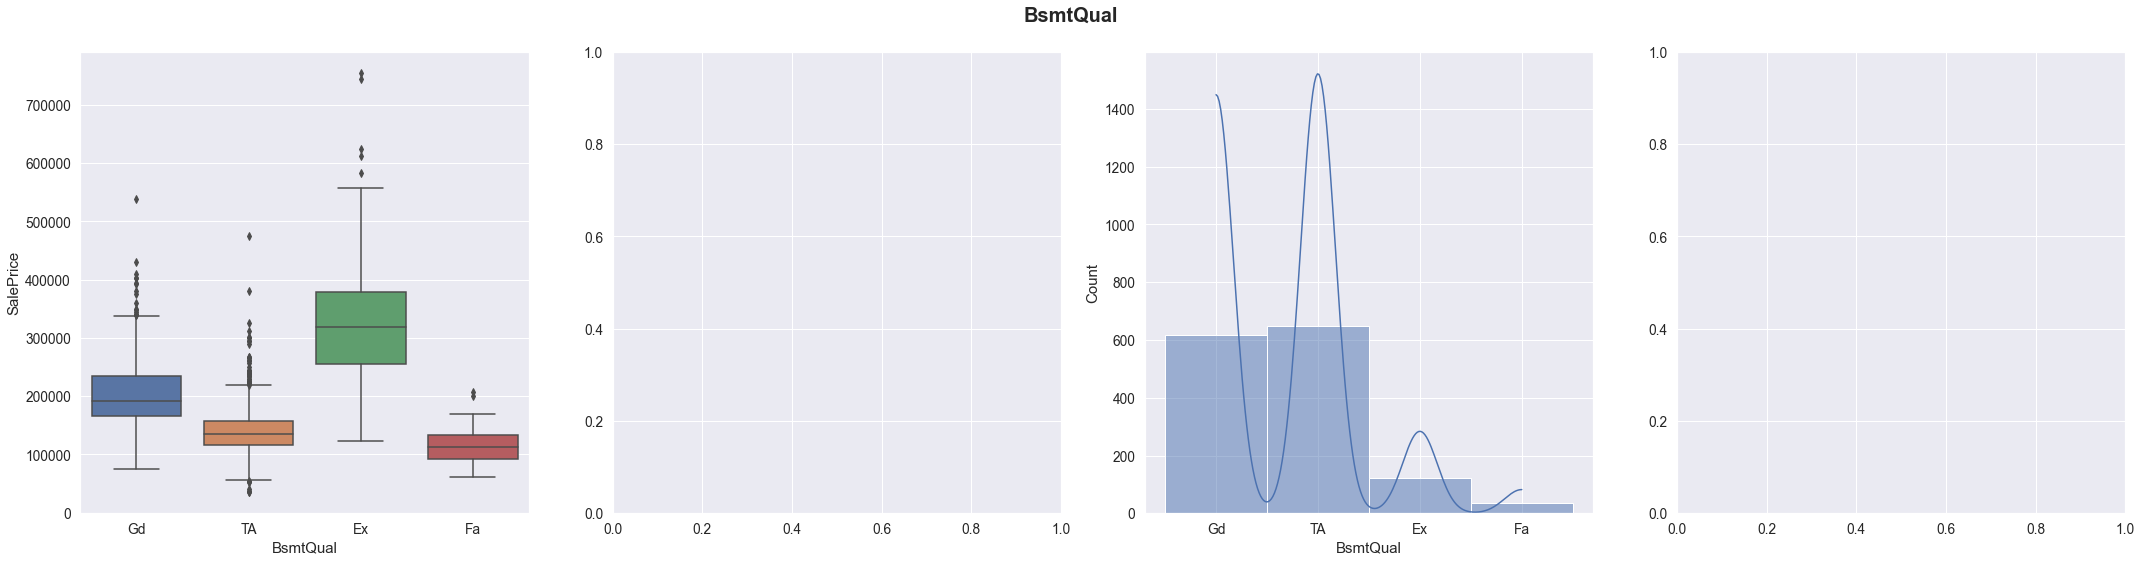

In [24]:
test_var_cat(df_train['BsmtQual'],df_train['SalePrice'])

##### ExterQual

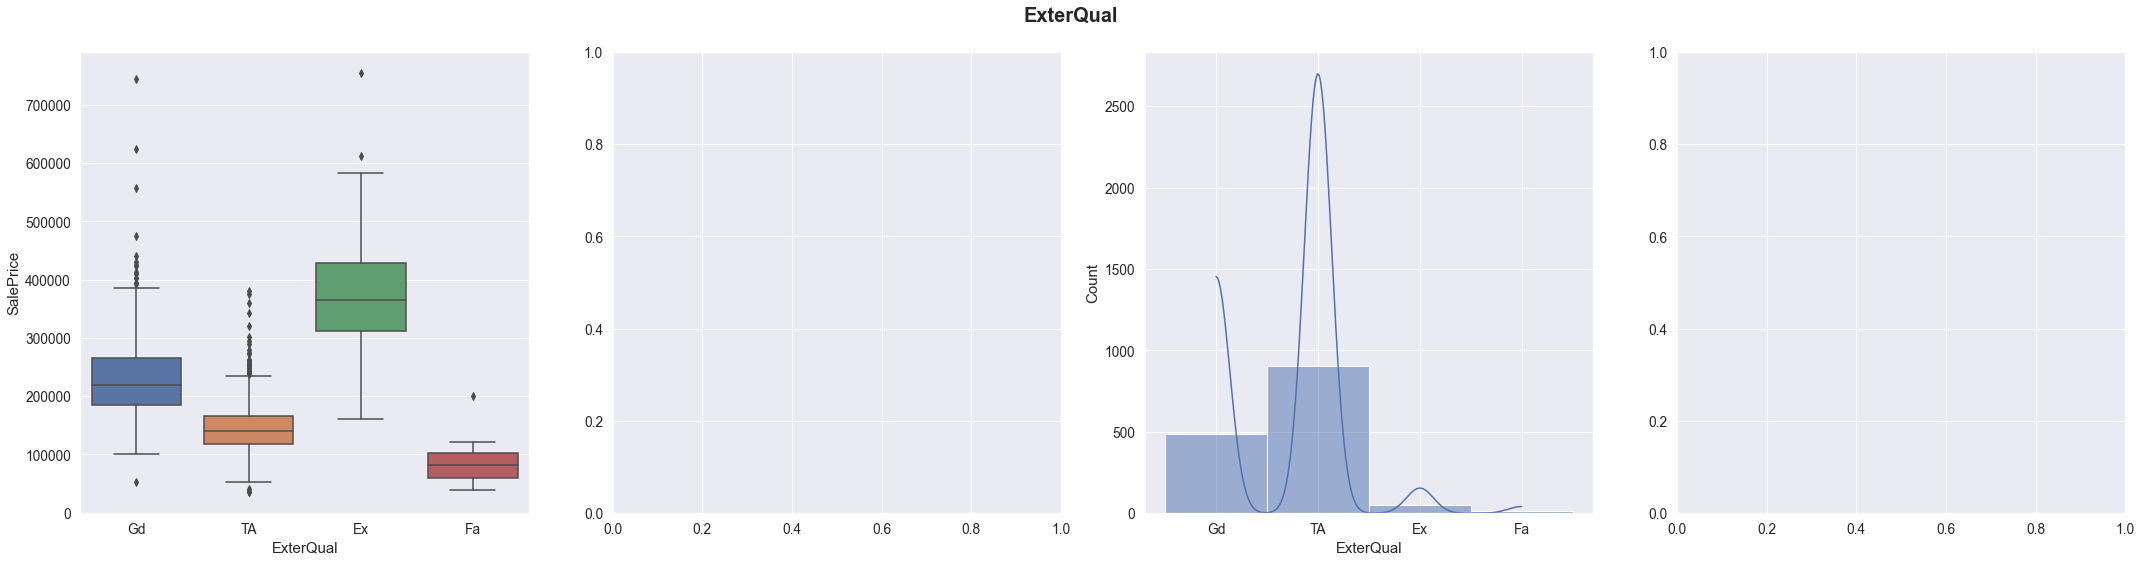

In [25]:
test_var_cat(df_train['ExterQual'],df_train['SalePrice'])

##### KitchenQual

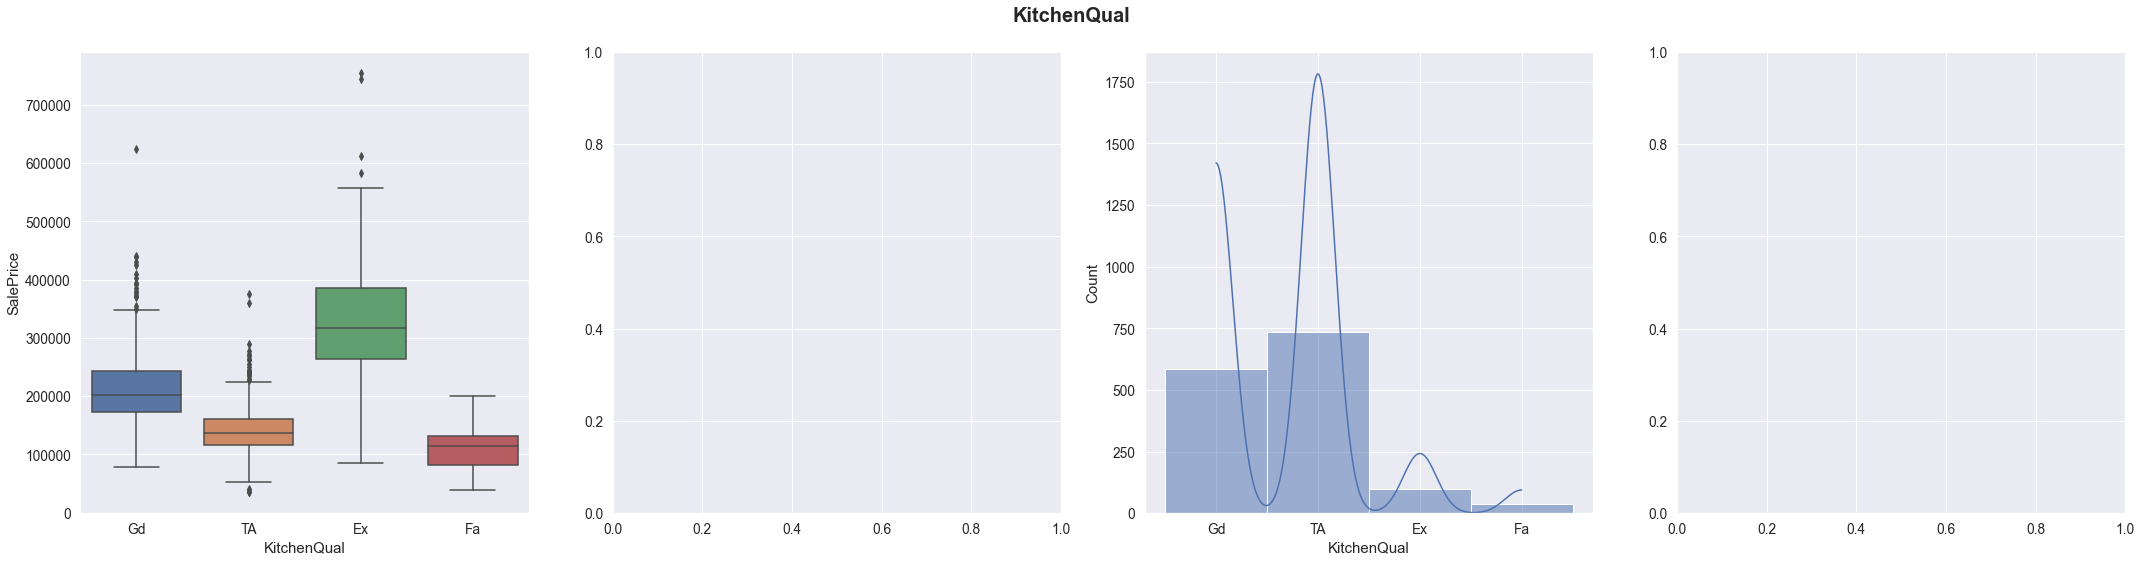

In [26]:
test_var_cat(df_train['KitchenQual'],df_train['SalePrice'])

#### FullBath

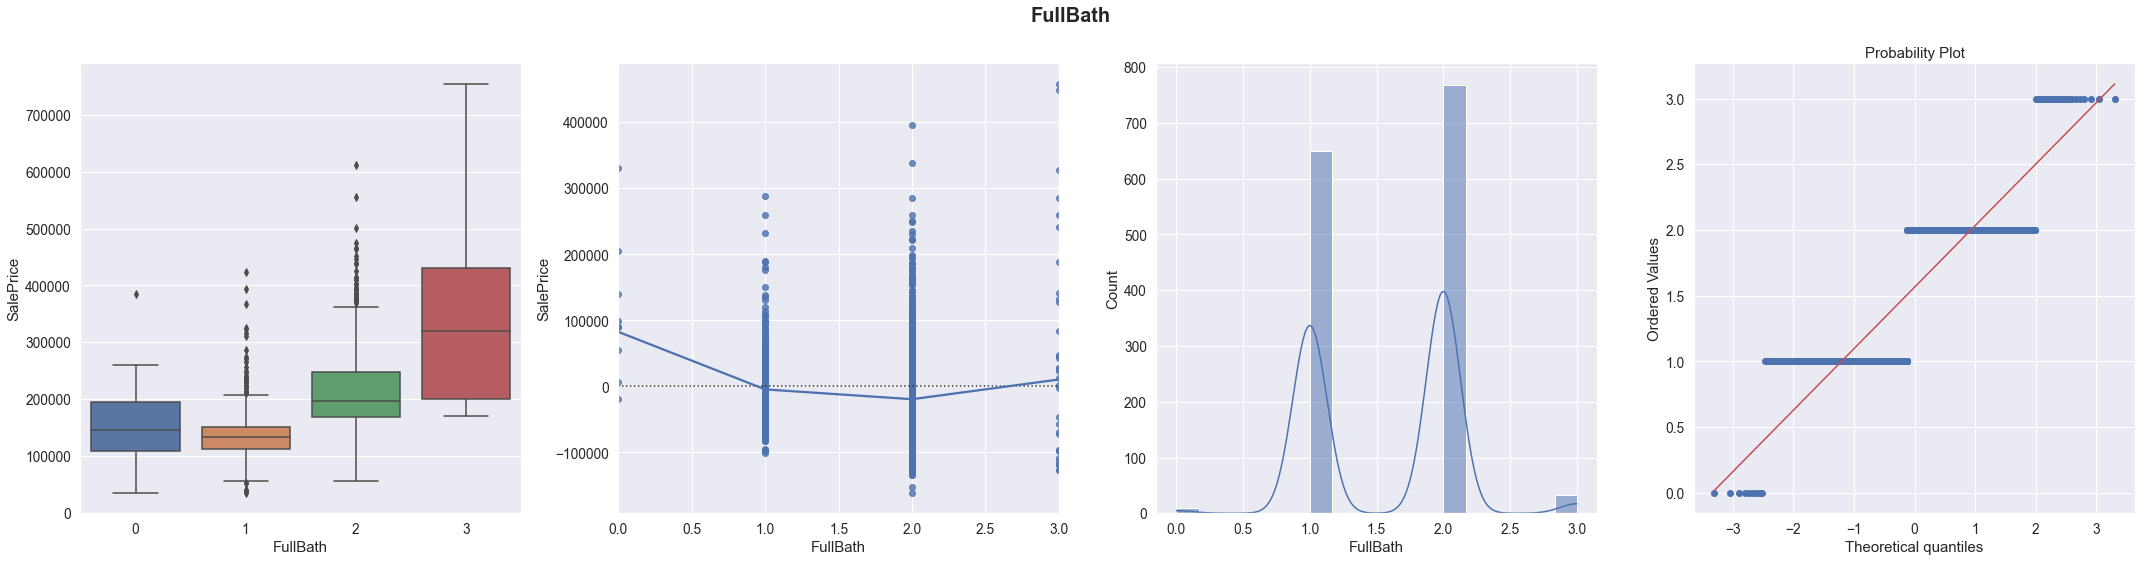

In [27]:
test_var_cat(df_train['FullBath'],df_train['SalePrice'],rank=True)

#### YearBuilt

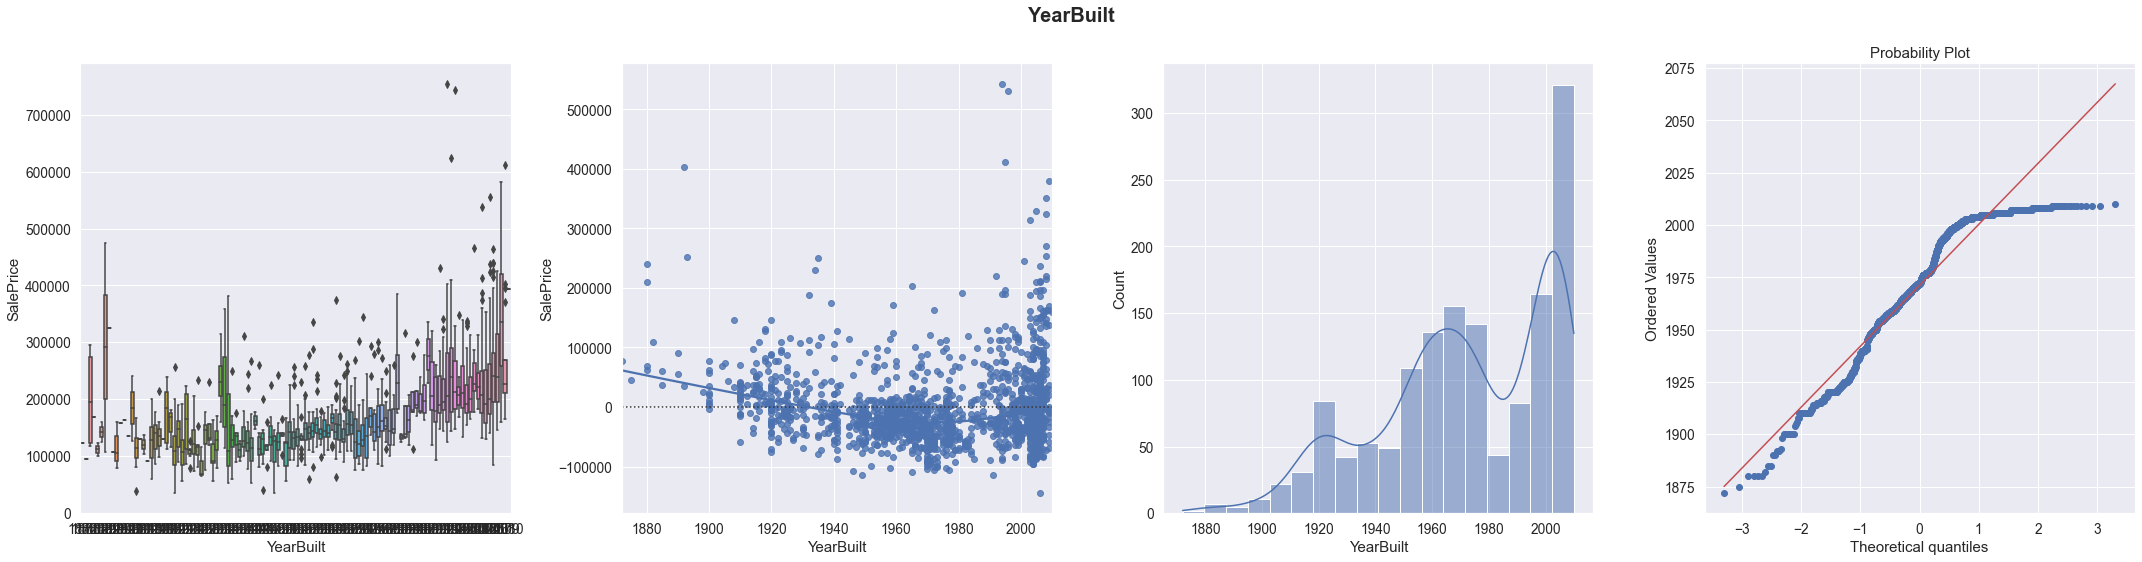

In [28]:
test_var_cat(df_train['YearBuilt'],df_train['SalePrice'],rank=True)

##### GarageFinish

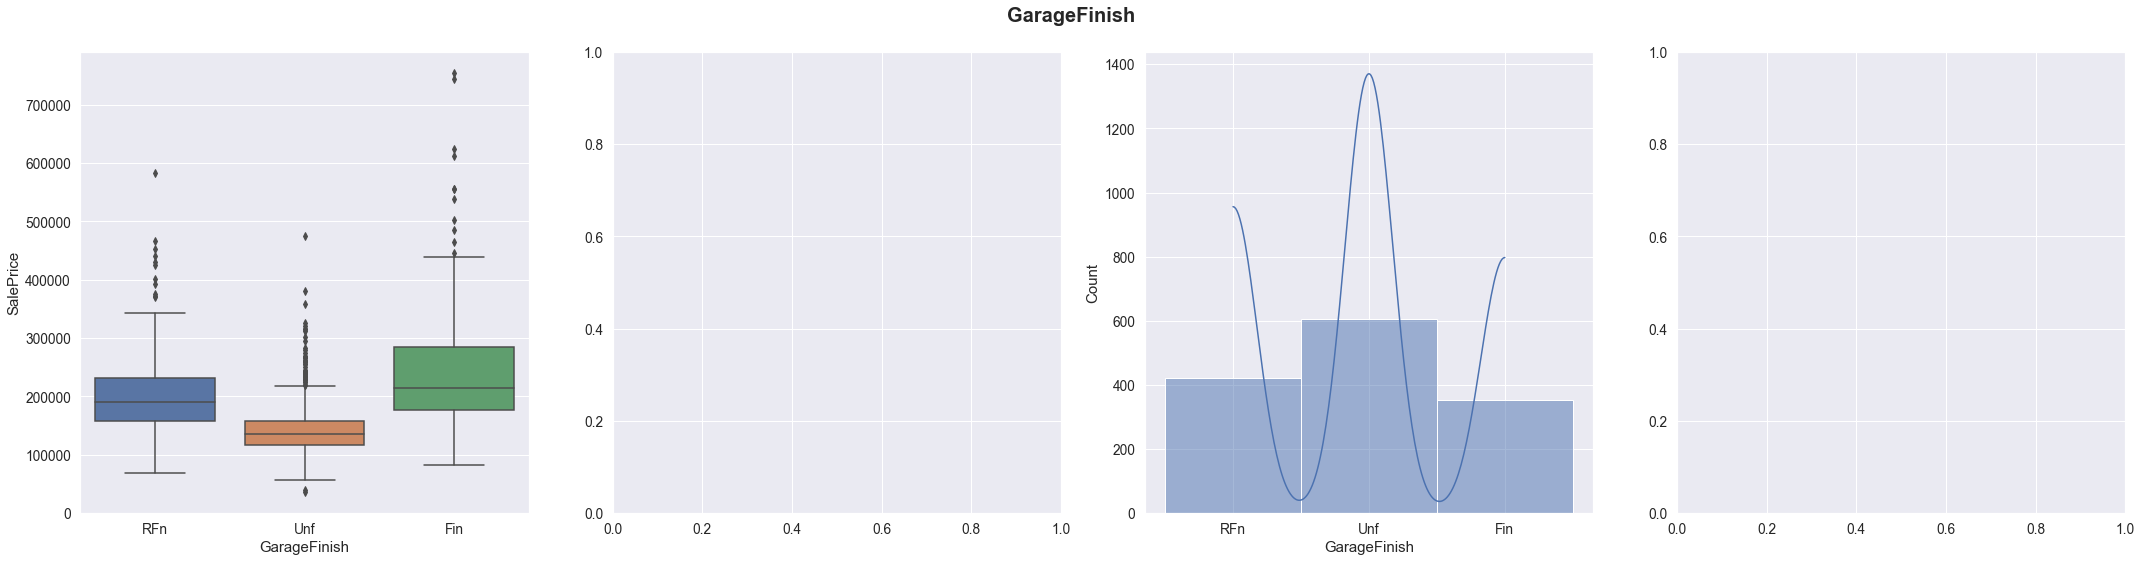

In [29]:
test_var_cat(df_train['GarageFinish'],df_train['SalePrice'])

##### Foundation

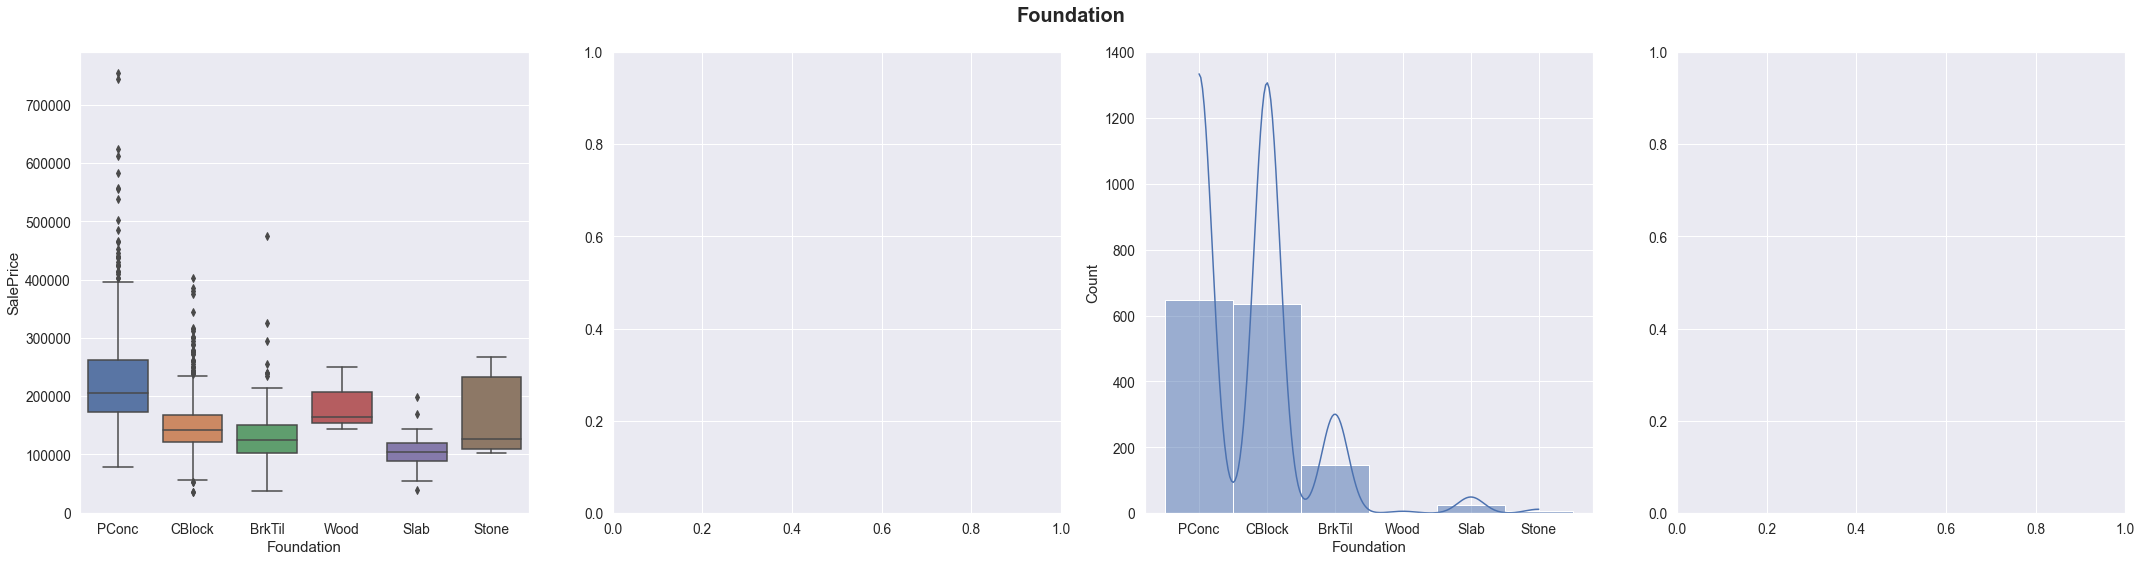

In [30]:
test_var_cat(df_train['Foundation'],df_train['SalePrice'])

##### YearRemodAdd

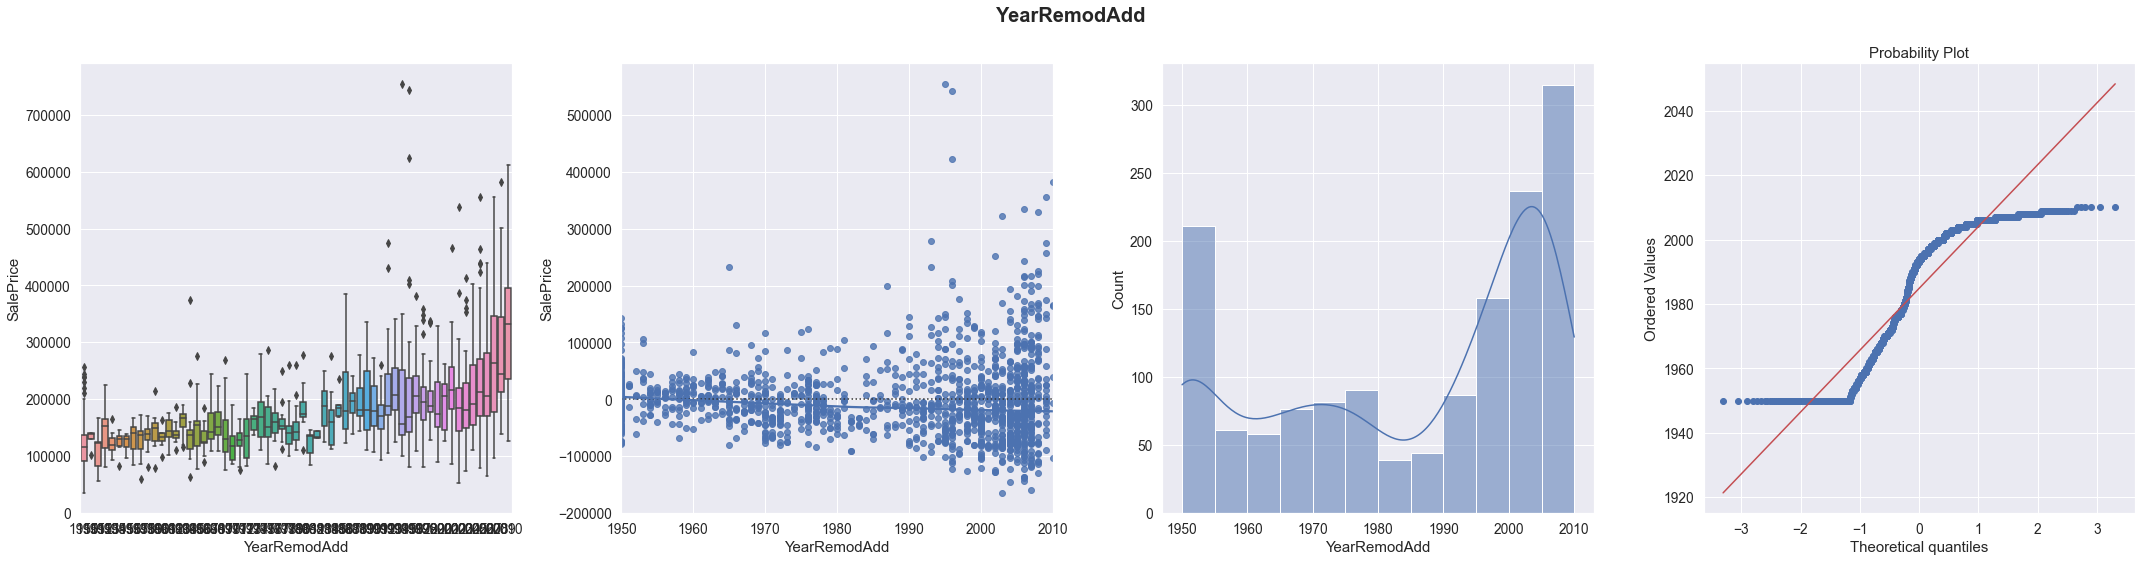

In [31]:
test_var_cat(df_train['YearRemodAdd'],df_train['SalePrice'],rank=True)

##### TotRmsAbvGrd

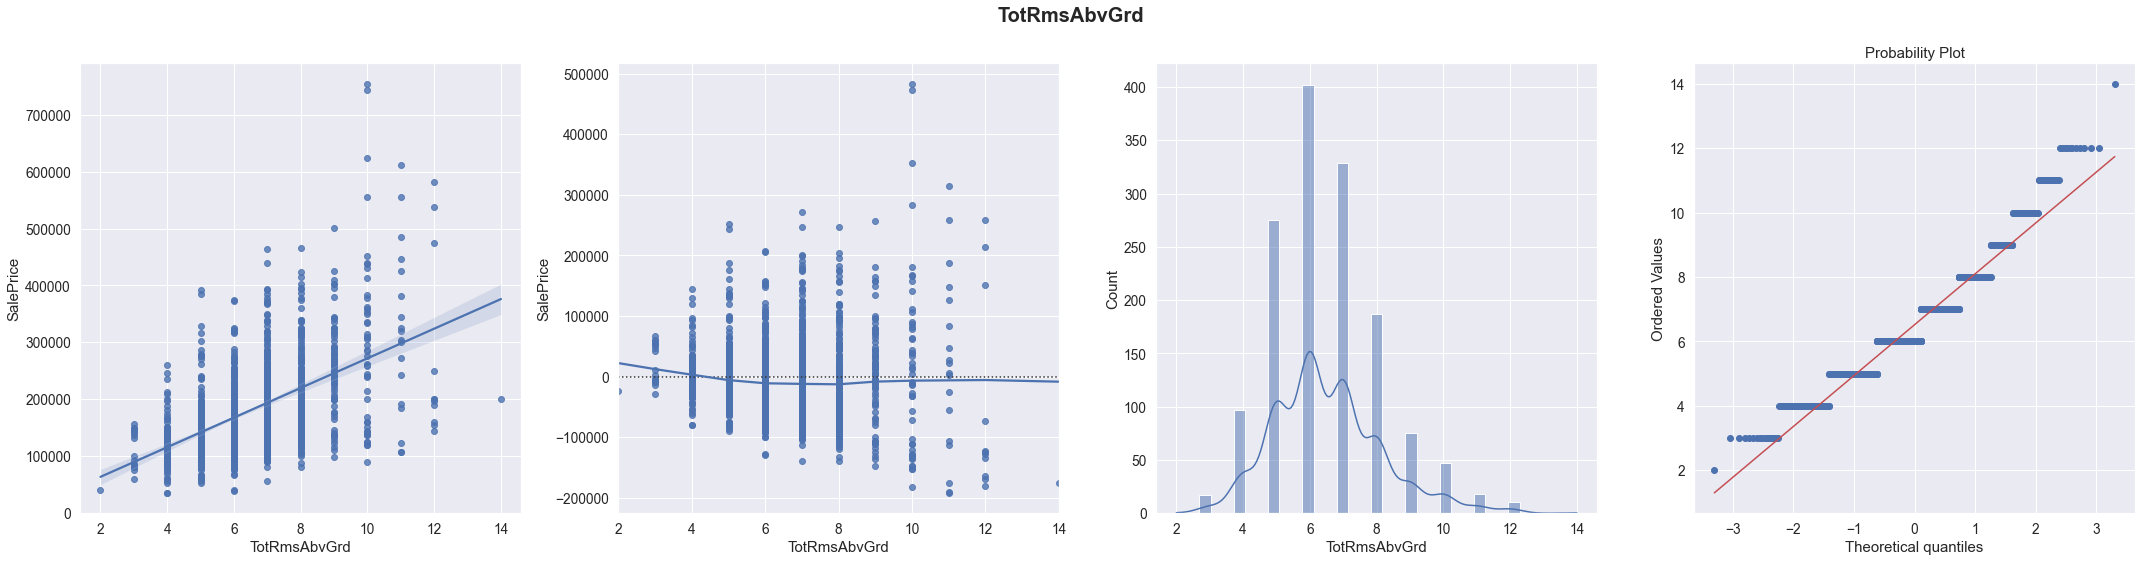

In [32]:
test_var_con(df_train['TotRmsAbvGrd'],df_train['SalePrice'])

##### Fireplaces

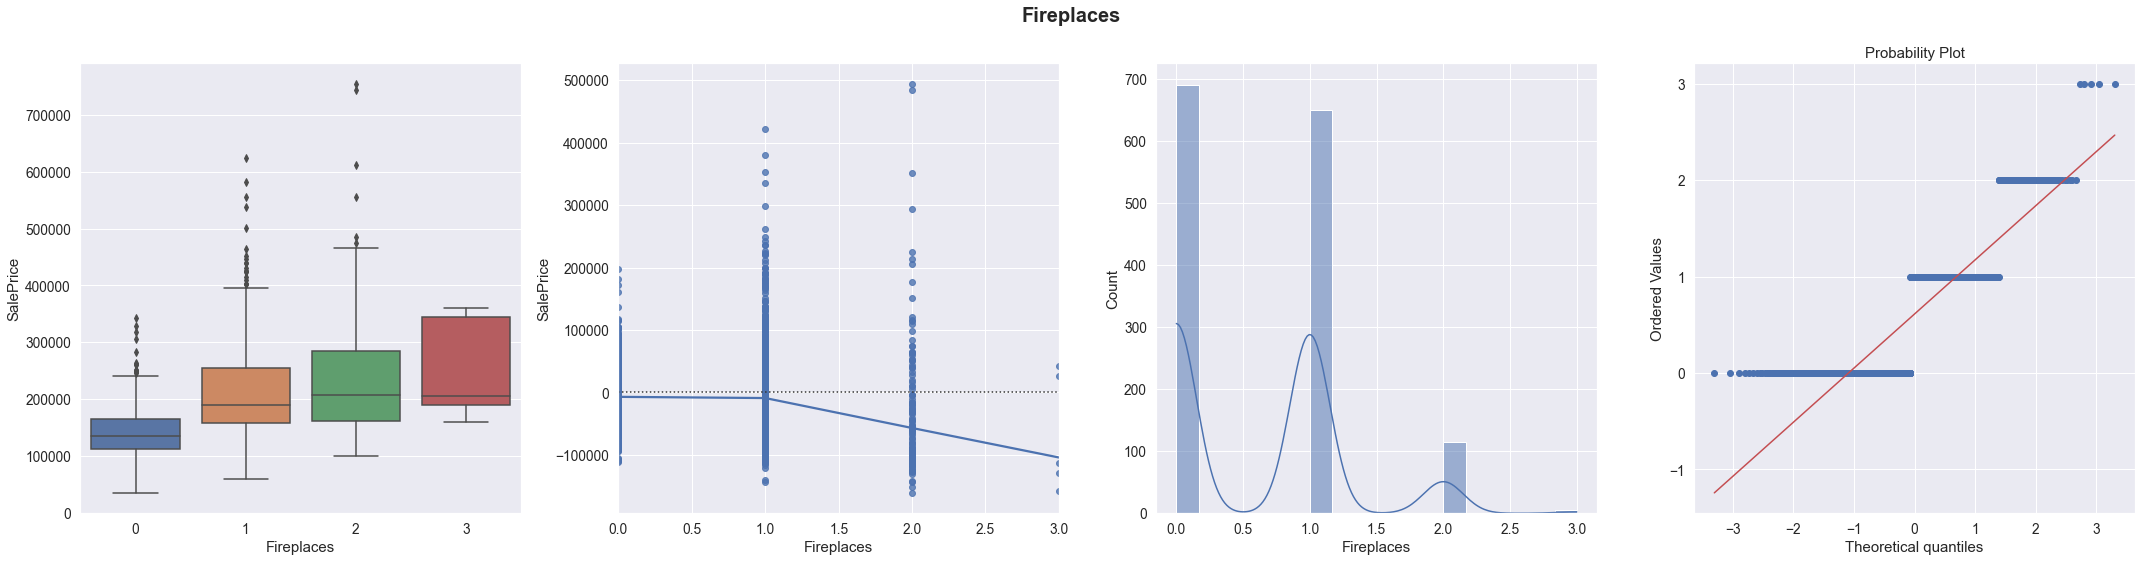

In [33]:
test_var_cat(df_train['Fireplaces'],df_train['SalePrice'],rank=True)

##### HeatingQC

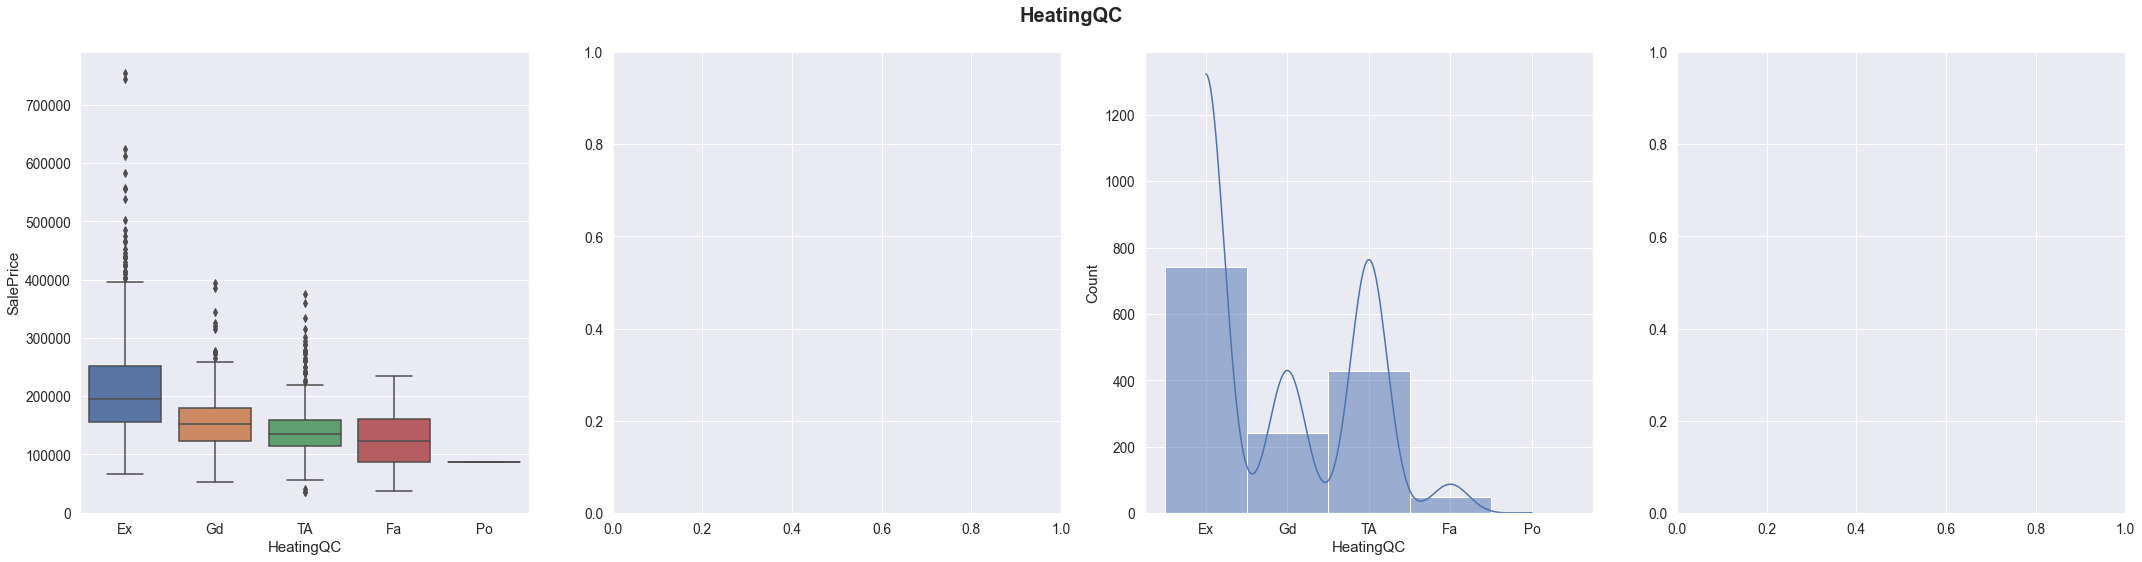

In [34]:
test_var_cat(df_train['HeatingQC'],df_train['SalePrice'])

##### OverallCond

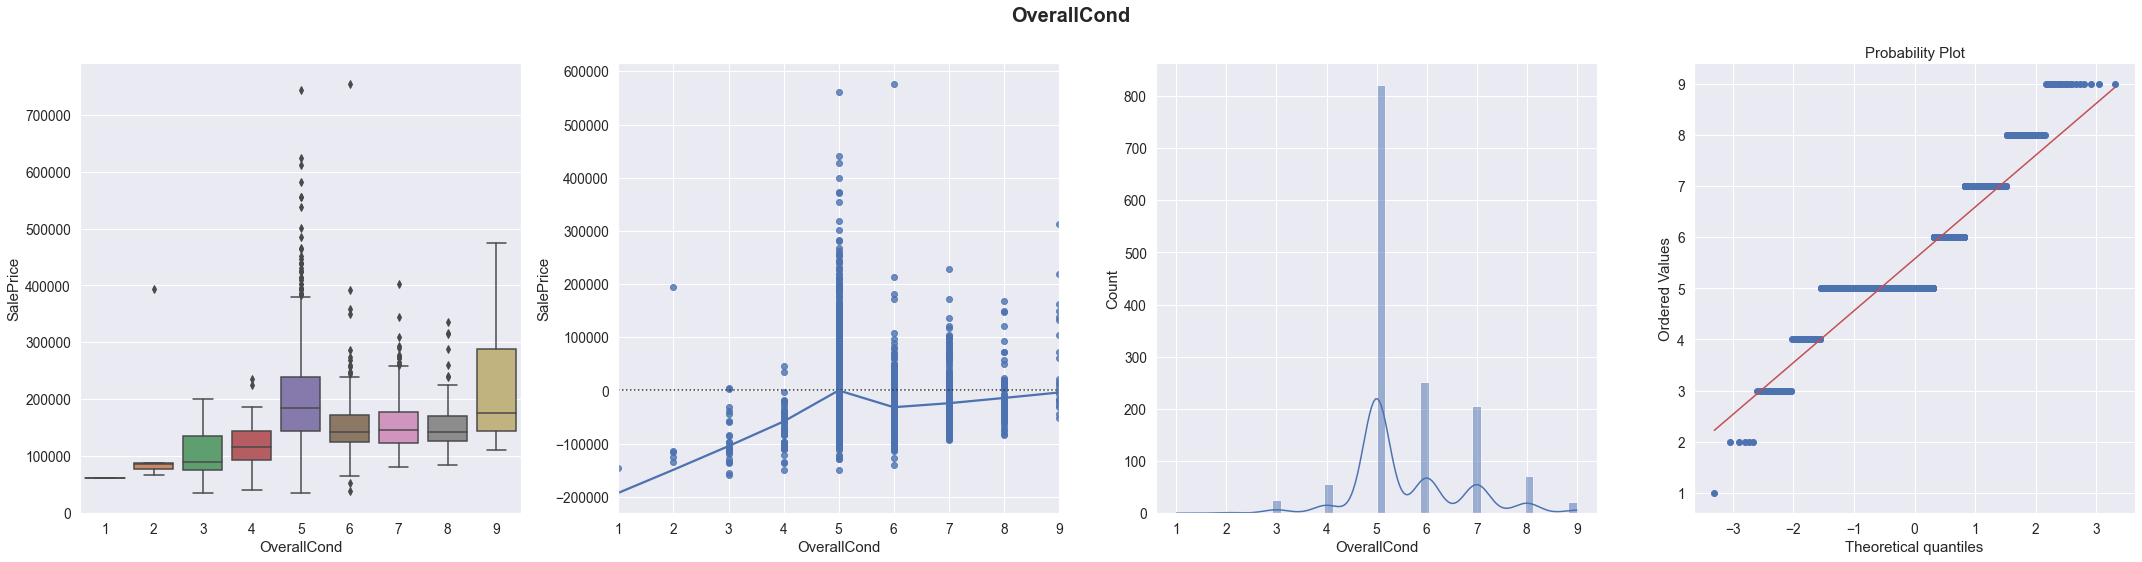

In [51]:
test_var_cat(df_train['OverallCond'],df_train['SalePrice'],rank=True)

##### Neighborhood

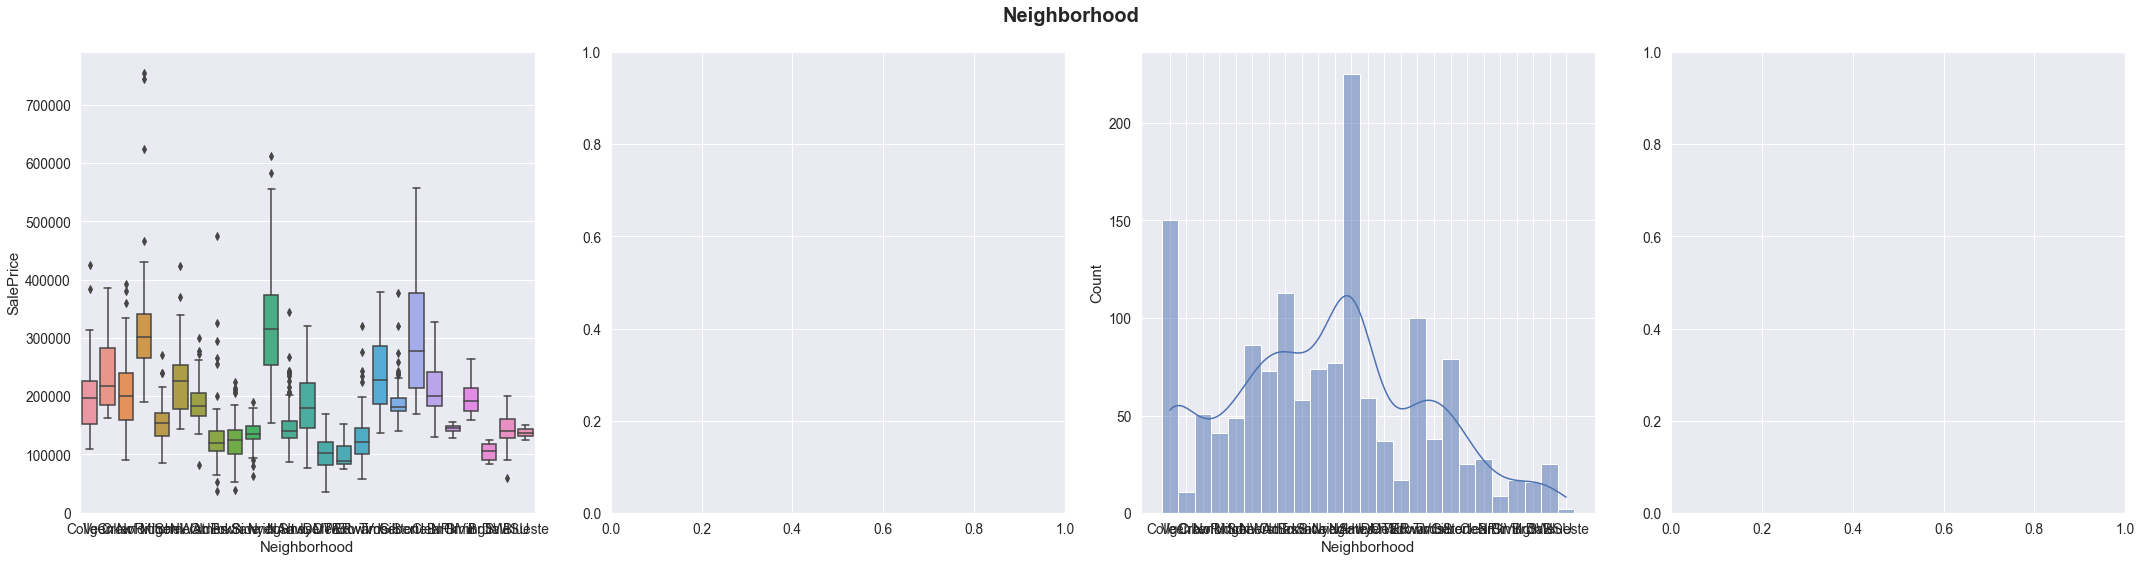

In [52]:
test_var_cat(df_train['Neighborhood'],df_train['SalePrice'])

##### MSZoning

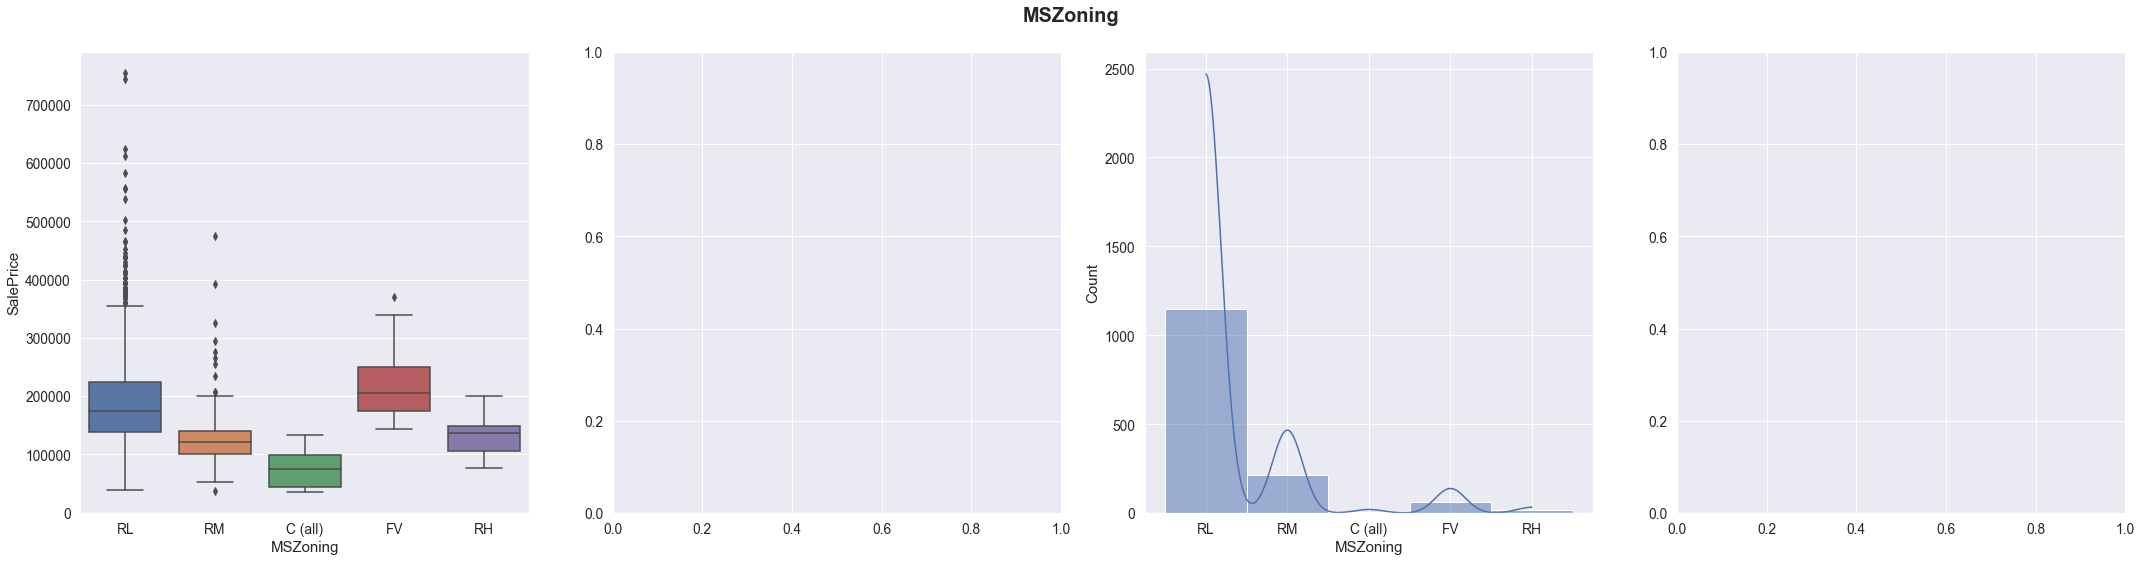

In [53]:
test_var_cat(df_train['MSZoning'],df_train['SalePrice'])

##### MasVnrType

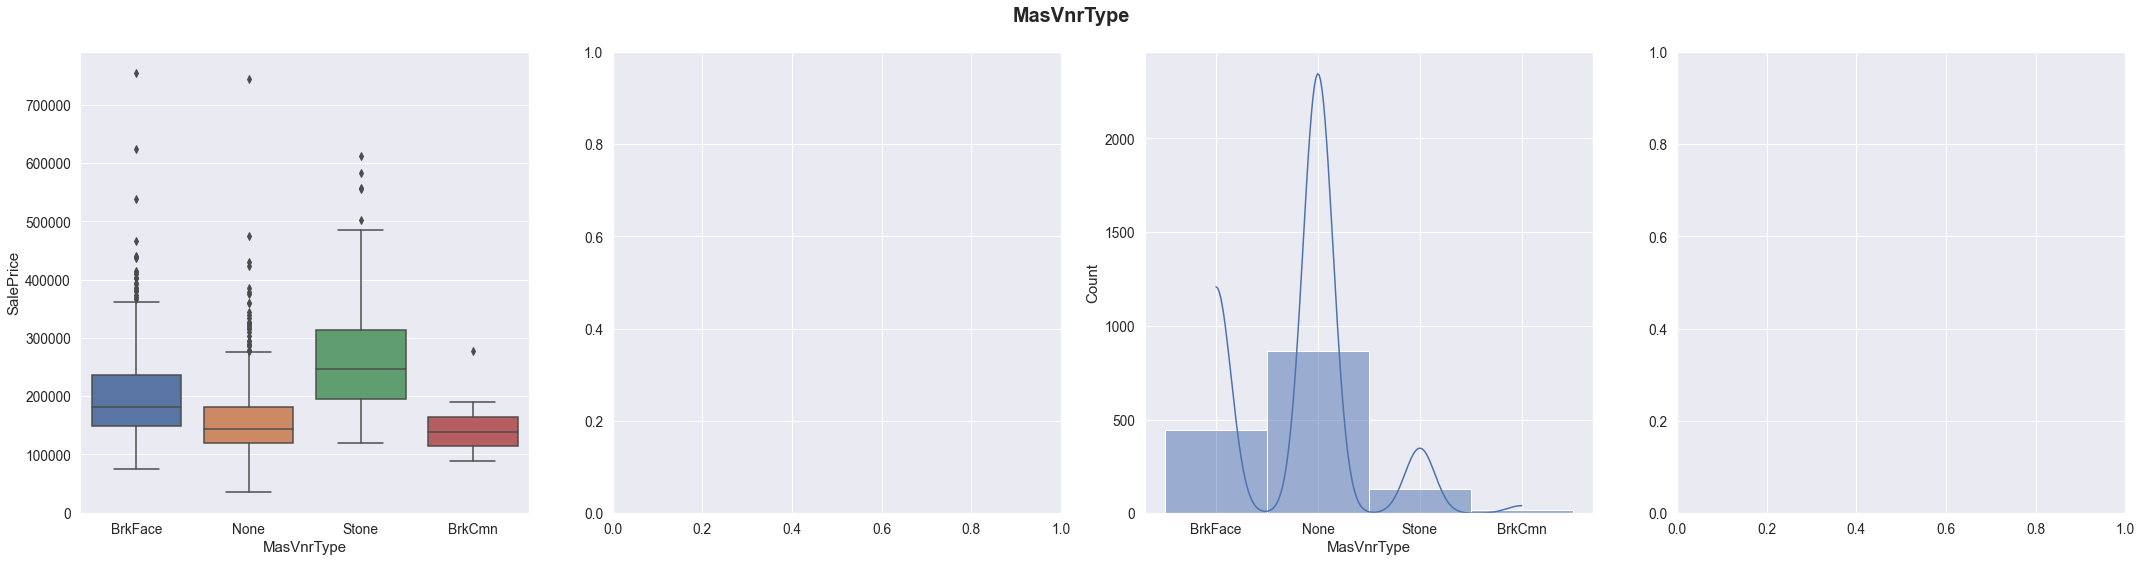

In [54]:
test_var_cat(df_train['MasVnrType'],df_train['SalePrice'])

In [35]:
mi_scores[:23].index

Index(['OverallQual', 'GrLivArea', 'GarageCars', 'BsmtQual', 'KitchenQual',
       'ExterQual', 'GarageArea', 'YearBuilt', 'FullBath', 'TotalBsmtSF',
       'GarageFinish', '1stFlrSF', 'YearRemodAdd', 'Foundation',
       'TotRmsAbvGrd', 'Fireplaces', 'HeatingQC', 'Neighborhood', 'MSZoning',
       'BsmtFinSF1', 'OverallCond', 'FireplaceQu', '2ndFlrSF'],
      dtype='object')

#### Mapa correlacion

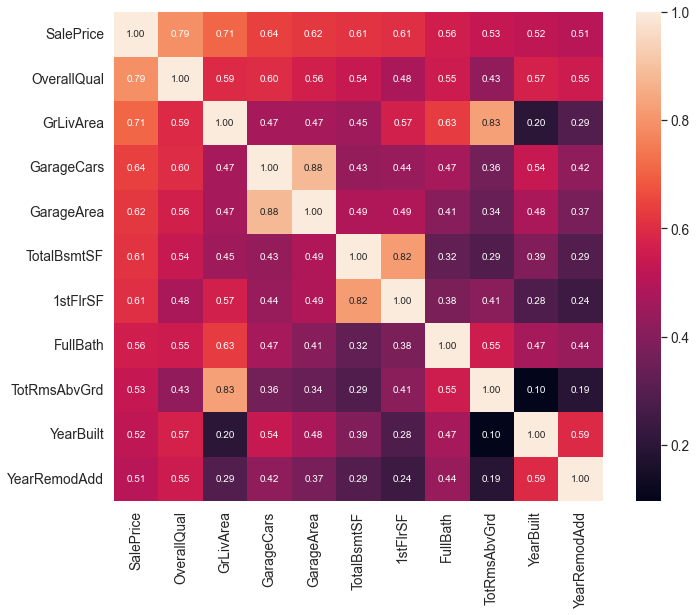

In [36]:
zoomed_corr_heatmap(df_train,11,'SalePrice')

Hay correlacion entre GarageArea y GarageCars

Hay correlacion entre TotalBsmtSF y 1stFlrSF


#### Analisis variables correlacion

##### OverallQual

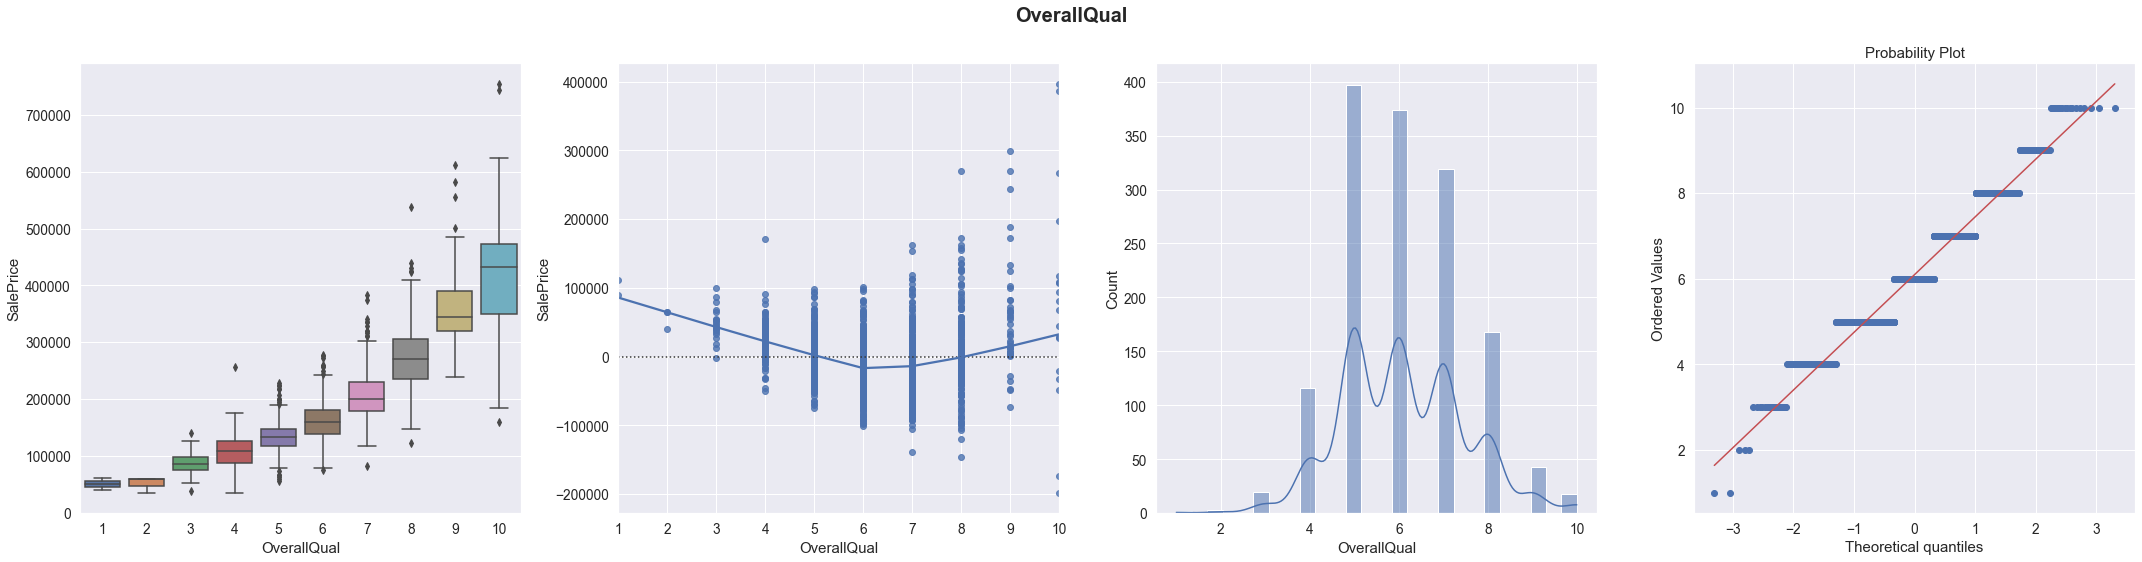

In [37]:
test_var_cat(df_train['OverallQual'],df_train['SalePrice'],rank=True)

In [38]:
df_train['OverallQual'].astype('category').describe()

count     1460
unique      10
top          5
freq       397
Name: OverallQual, dtype: int64

##### GrLivArea

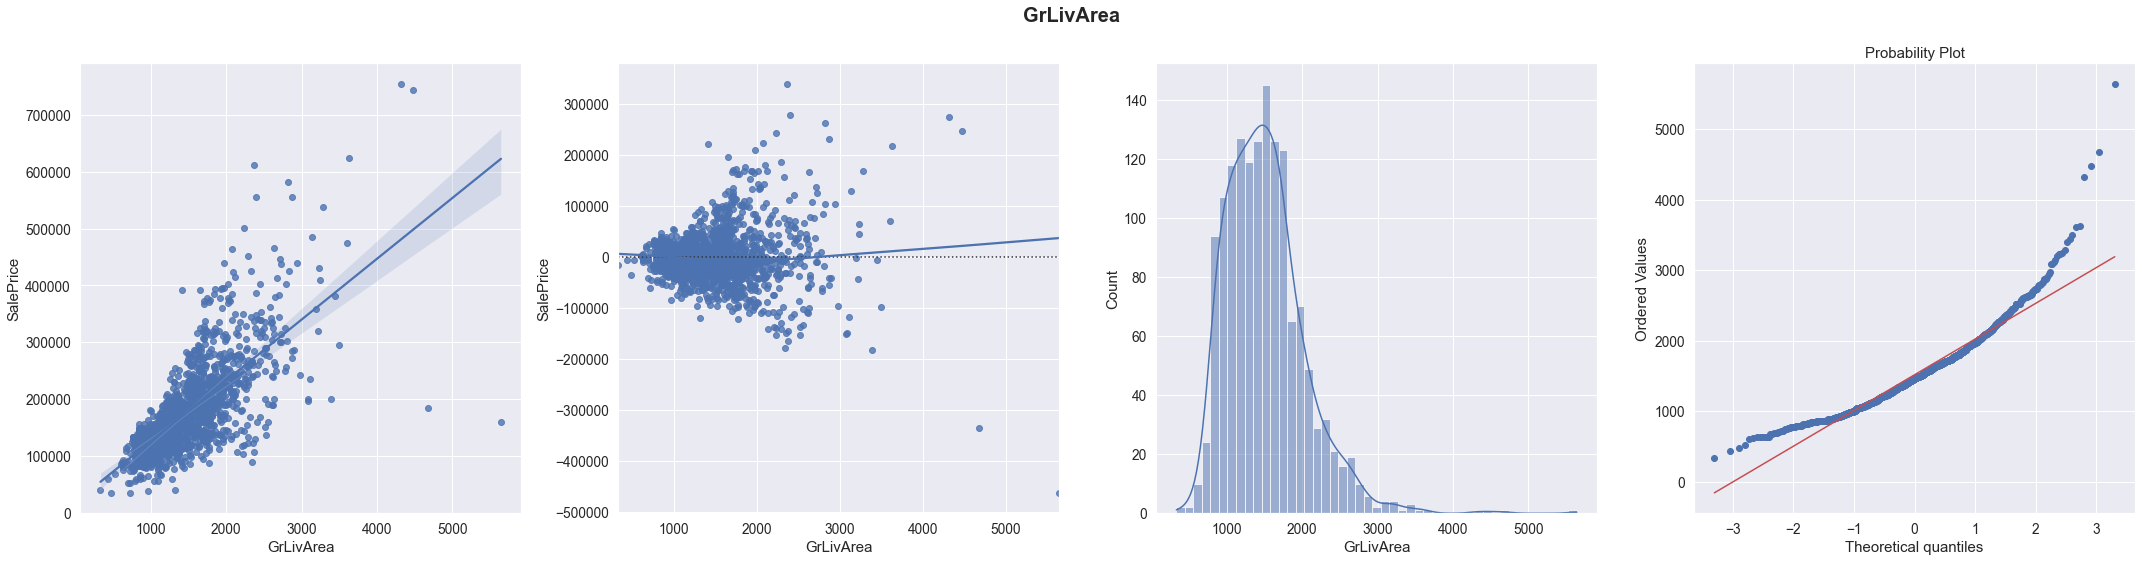

In [39]:
test_var_con(df_train['GrLivArea'],df_train['SalePrice'])

In [40]:
df_train['GrLivArea'].describe()

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

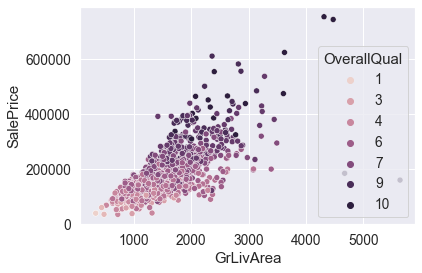

In [41]:
sns.scatterplot(data=df_train,x='GrLivArea',y='SalePrice',hue='OverallQual')

##### GarageArea

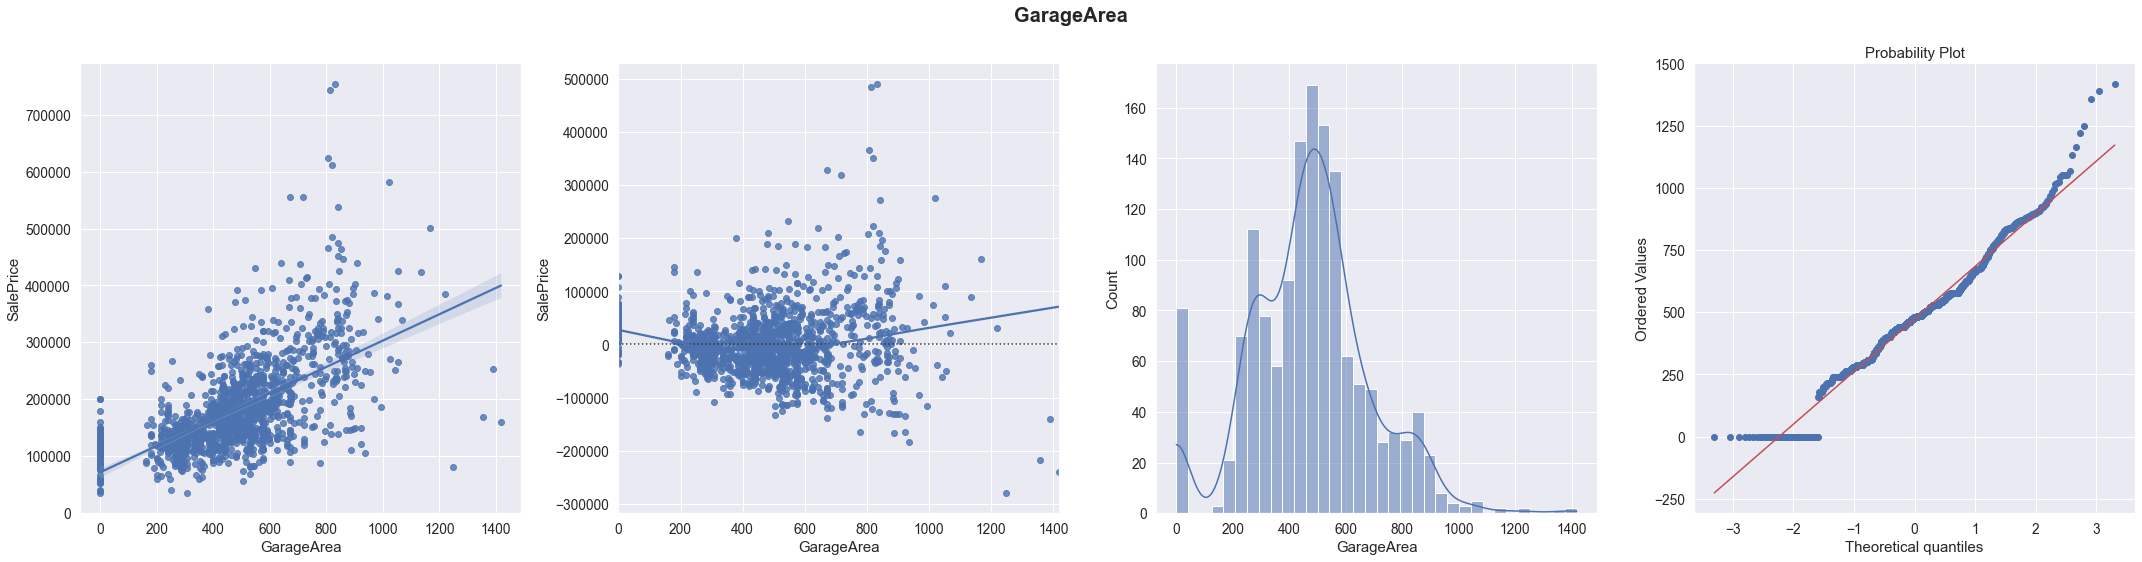

In [42]:
test_var_con(df_train['GarageArea'],df_train['SalePrice'])

In [43]:
df_train['GarageArea'].describe()

count    1460.000000
mean      472.980137
std       213.804841
min         0.000000
25%       334.500000
50%       480.000000
75%       576.000000
max      1418.000000
Name: GarageArea, dtype: float64

##### TotalBsmtSF

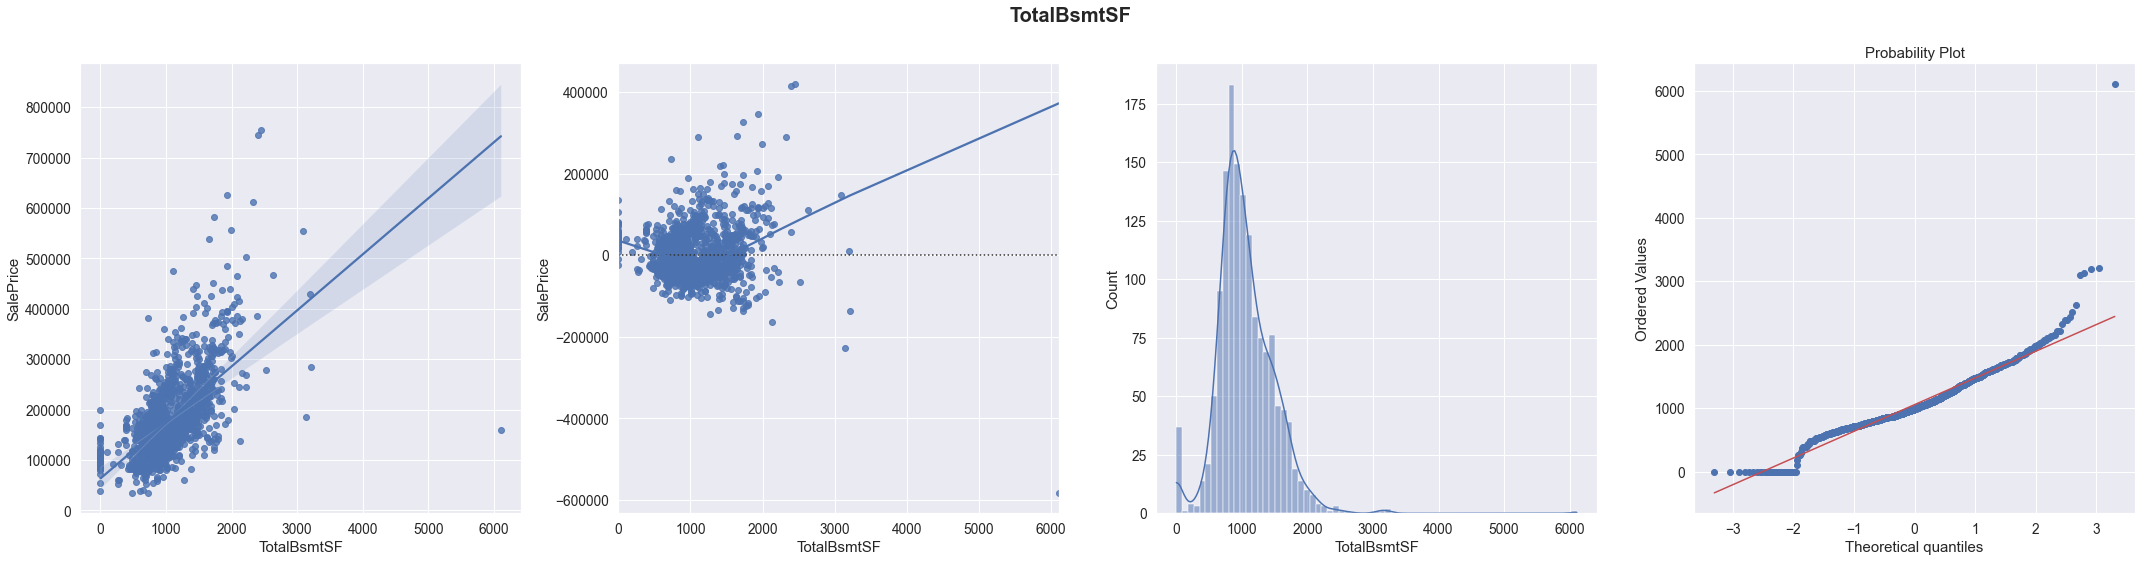

In [44]:
test_var_con(df_train['TotalBsmtSF'],df_train['SalePrice'])

In [45]:
df_train['TotalBsmtSF'].describe()

count    1460.000000
mean     1057.429452
std       438.705324
min         0.000000
25%       795.750000
50%       991.500000
75%      1298.250000
max      6110.000000
Name: TotalBsmtSF, dtype: float64

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

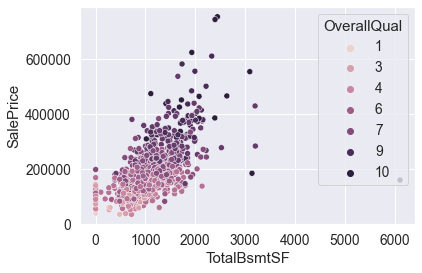

In [46]:
sns.scatterplot(data=df_train,x='TotalBsmtSF',y='SalePrice',hue='OverallQual')

##### 1stFlrSF

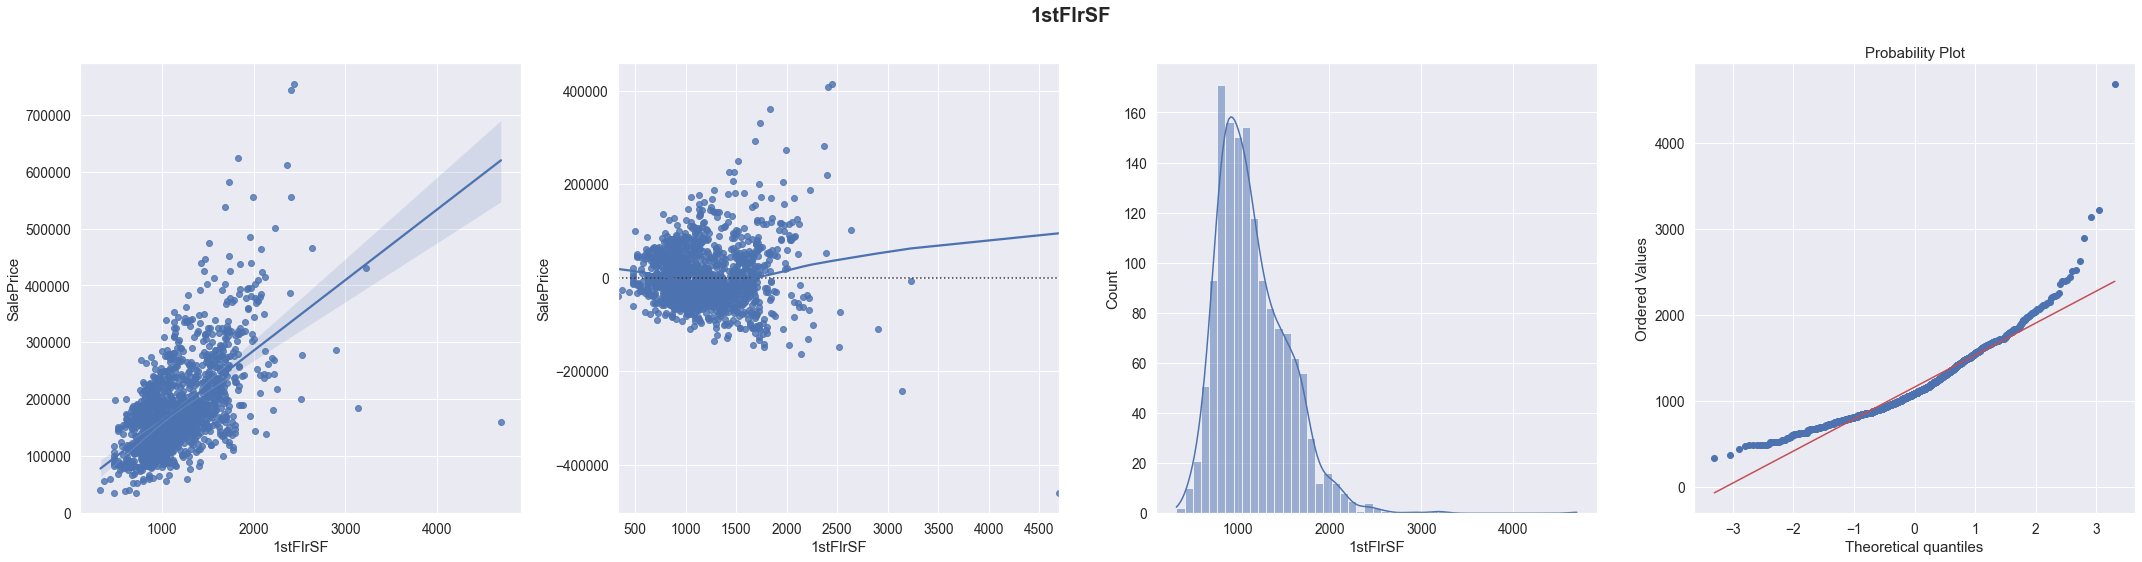

In [47]:
test_var_con(df_train['1stFlrSF'],df_train['SalePrice'])

In [48]:
df_train['YearBuilt'].astype('category').describe()

count     1460
unique     112
top       2006
freq        67
Name: YearBuilt, dtype: int64

In [49]:
df_train['FullBath'].astype('category').describe()

count     1460
unique       4
top          2
freq       768
Name: FullBath, dtype: int64

#### Analisis variables categoricas

##### Univariate

In [38]:
def barplot_categorias(data,categorical):
    fill_missing_cat_columns(data,categorical)
    f=pd.melt(data,value_vars=categorical)
    g=sns.FacetGrid(f,col='variable',col_wrap=5,sharex=False,sharey=False,height=5)
    g=g.map(sns.countplot,'value',orient='v')
    g.set_xticklabels(rotation=90,fontsize='small',fontweight='light')
    g.fig.tight_layout()

c:\Users\djm98\OneDrive\Escritorio\house_price_kaggle\.venv\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


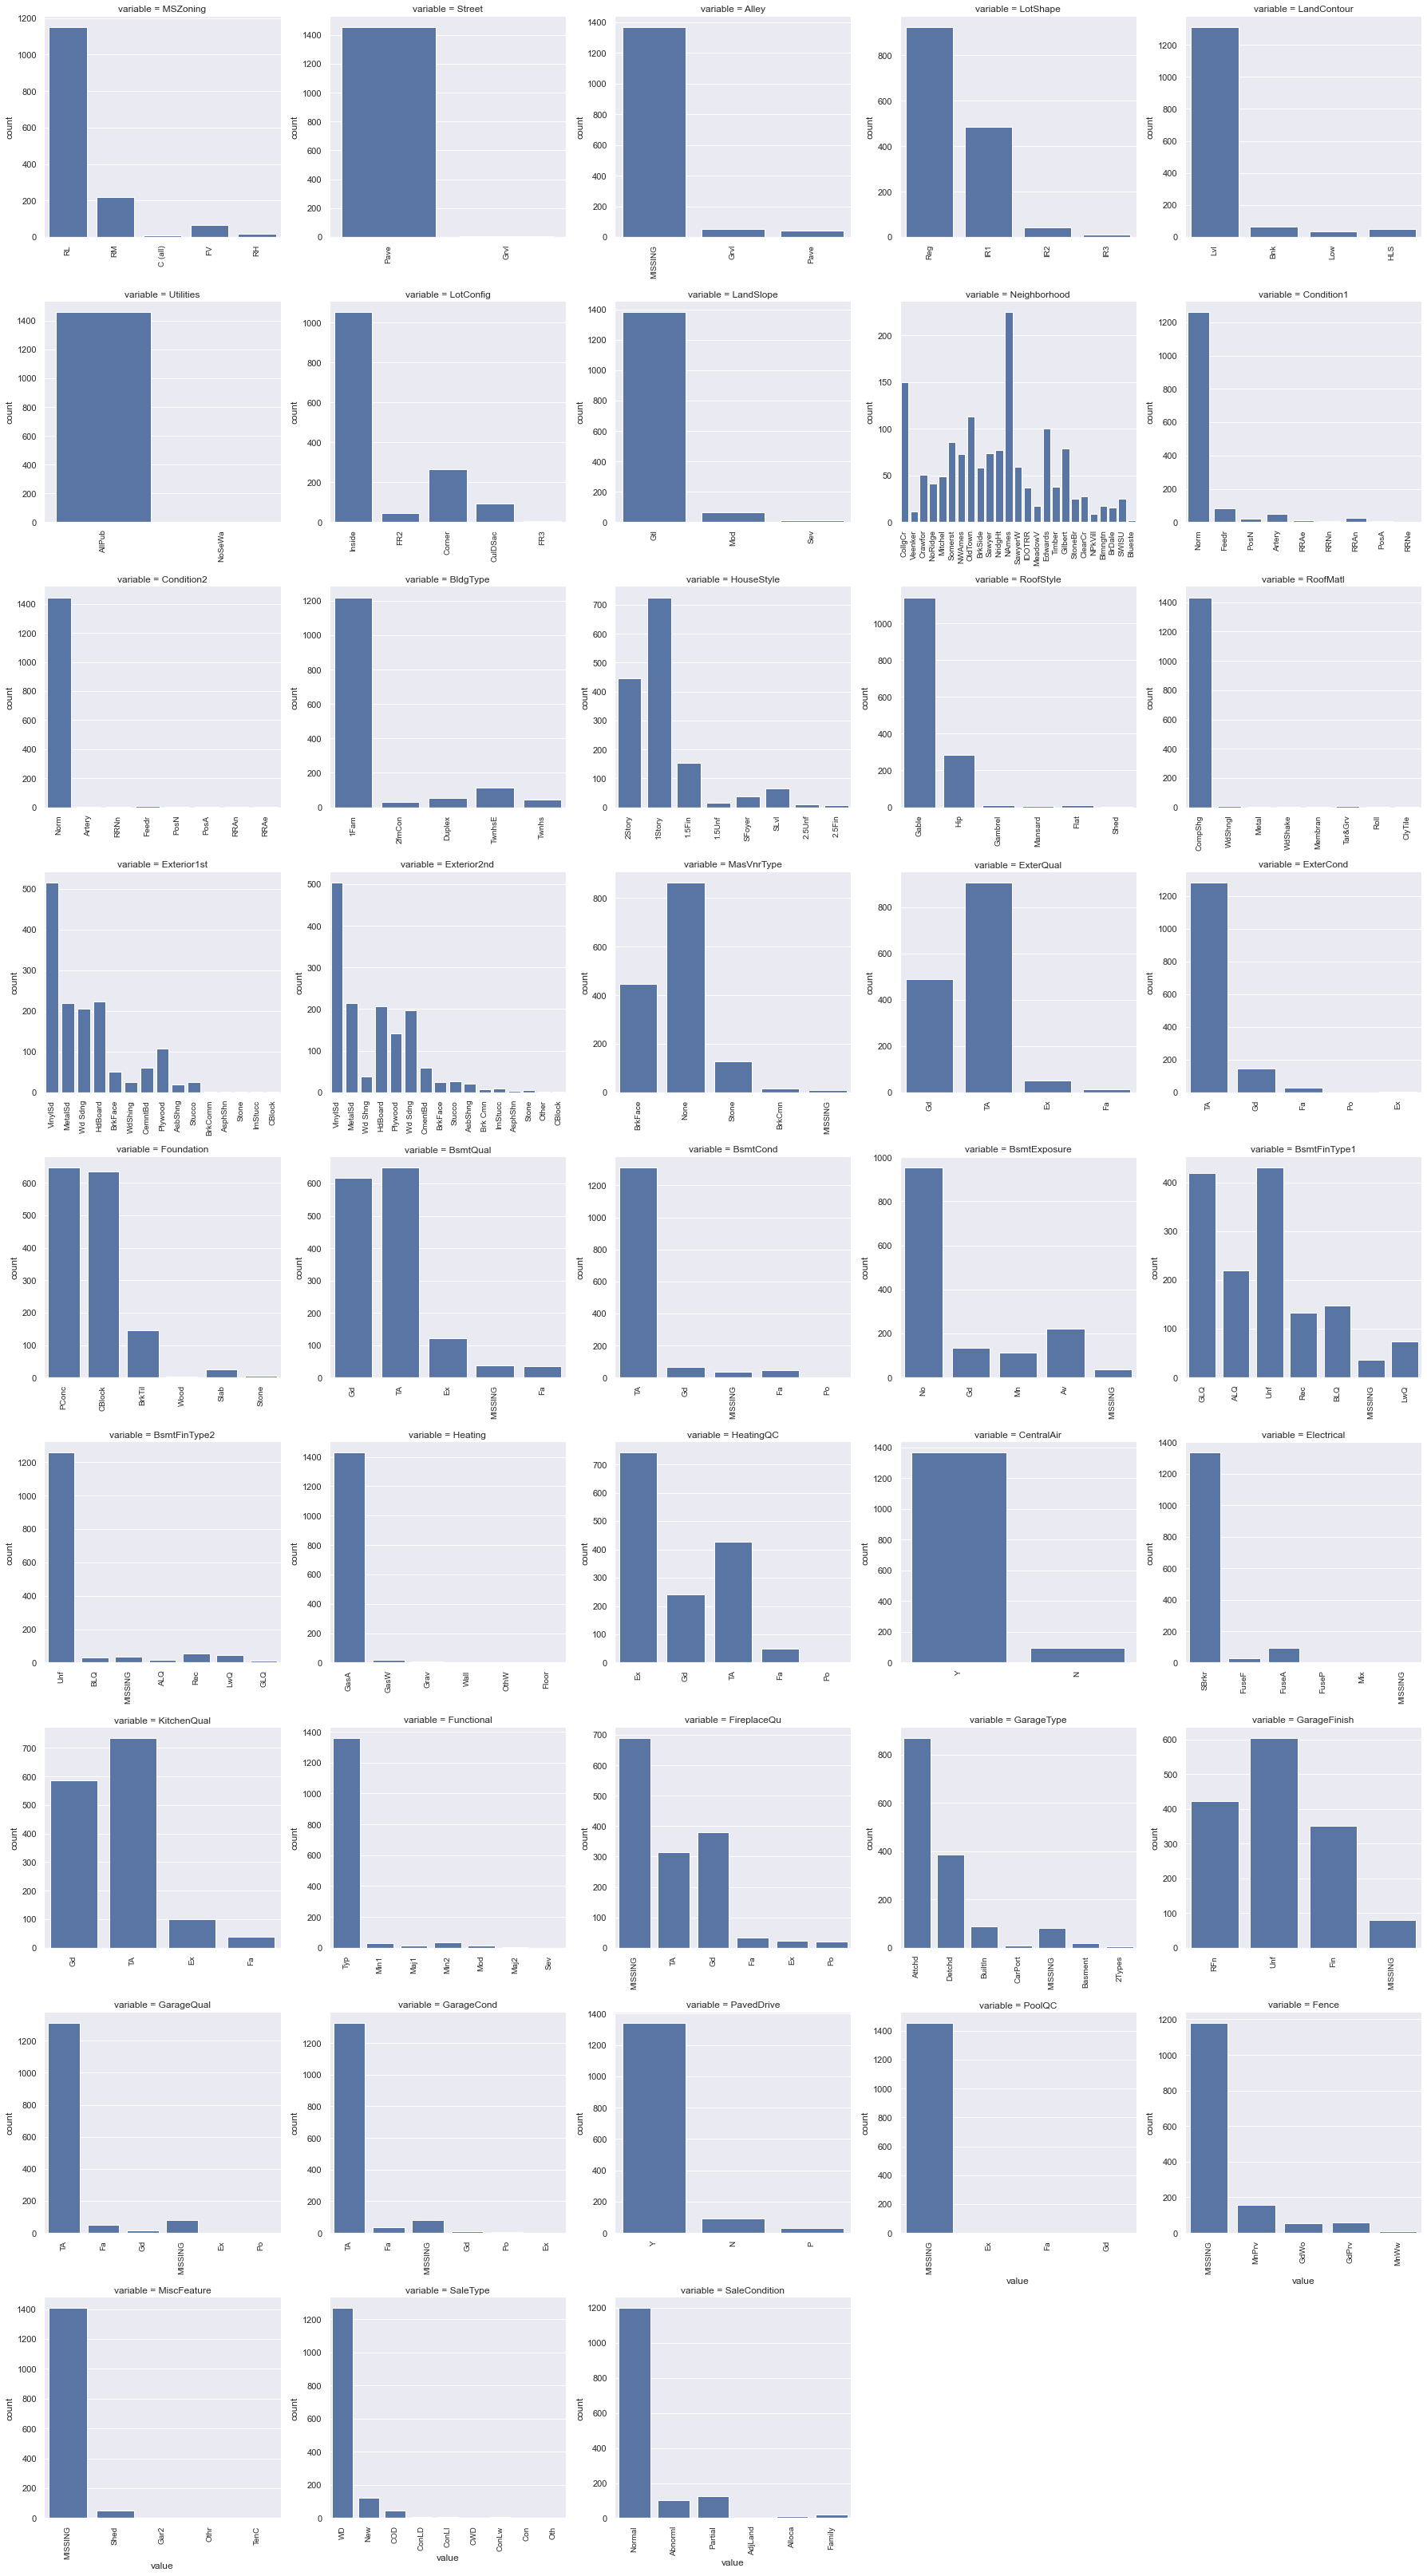

In [41]:
data = df_train.copy()
categorical = data.select_dtypes('object')
barplot_categorias(data,categorical)

##### Bivariate

In [ ]:
def boxplot(x,y,**kwargs):
    sns.boxplot(x=x,y=y)
    plt.xticks(rotation=90)

def get_boxplots(data,var,categorical):
    fill_missing_cat_columns(data,categorical)
    #Esta funcion convierte a var en un indice y agrupa todas las columnas de categorical en una columna variable y otra valor
    f=pd.melt(data,id_vars=var,value_vars=categorical)
    #Defino el numero de columnas como la cantidad de variables
    g=sns.FacetGrid(f,col='variable',col_wrap=5,sharex=False,sharey=False,height=5)
    #Hago un map con la funcion boxplot, utilizando como x la columna values del df f, y como el input var
    g=g.map(boxplot,'value',var)


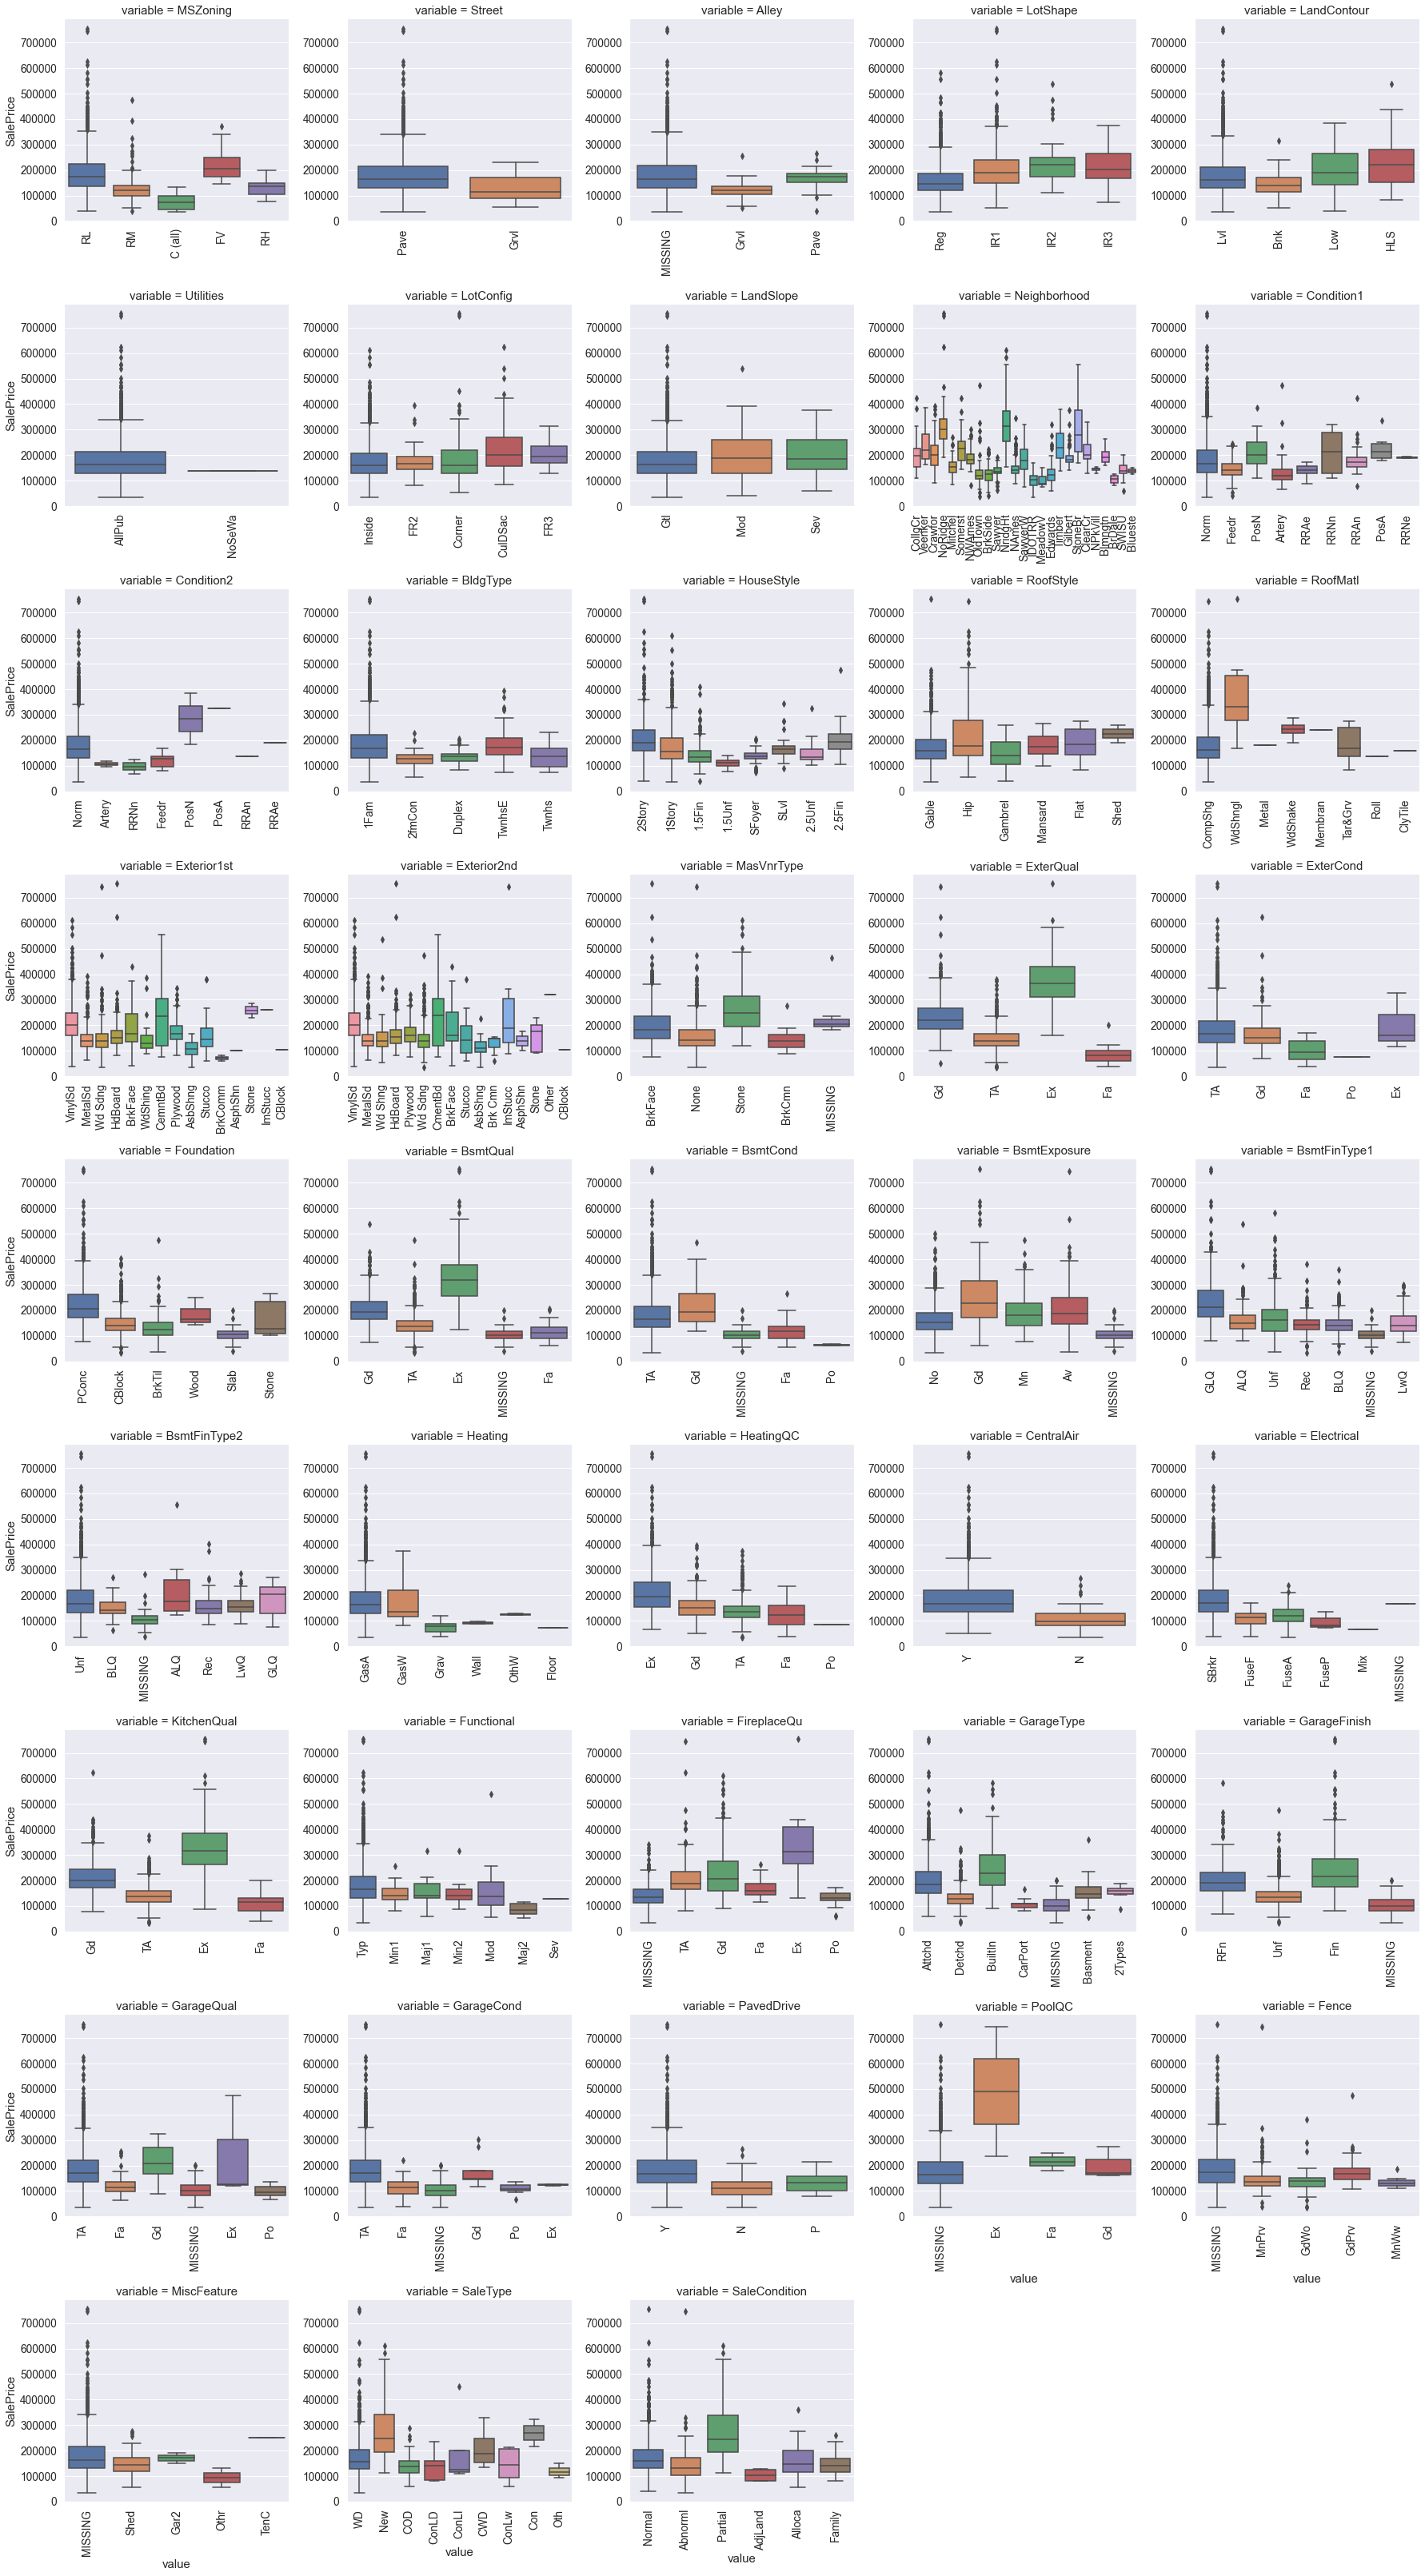

In [ ]:
get_boxplots(data,'SalePrice',categorical)

<ul>
    <li>HeatingQC </li>
    <li>Street</li>
    <li>LotShape</li>
    <li>LandSlope</li>
    <li>CentralAir</li>
<lu>
Tiene una relacion lineal con SalesPrice


In [ ]:
categorical.describe()

MSZoning Street Alley LotShape  ...  Fence MiscFeature SaleType SaleCondition
count      1460   1460    91     1460  ...    281          54     1460          1460
unique        5      2     2        4  ...      4           4        9             6
top          RL   Pave  Grvl      Reg  ...  MnPrv        Shed       WD        Normal
freq       1151   1454    50      925  ...    157          49     1267          1198

[4 rows x 43 columns]

In [ ]:
"""
data = df_train.copy()
lotshape_encoder = OneHotEncoder()
lotshape_reshaped = np.array(df_train['LotShape']).reshape(-1,1)
lotshape_values = lotshape_encoder.fit_transform(lotshape_reshaped)
col = np.char.lstrip(lotshape_encoder.get_feature_names_out().astype('str'), 'x0_')
df_lotshape = pd.DataFrame(lotshape_values.toarray(),columns=col)
df_encoding = pd.concat([df_train['SalePrice'],df_lotshape],axis='columns')
df_encoding['lotshape'] = (df_encoding.iloc[:, 2:] == 1).idxmax(1)
df_encoding = df_encoding.melt(id_vars='lotshape',value_vars=['SalePrice'])
"""
#sns.boxplot(x='lotshape', y='value', data=df_encoding, palette="Set3")

# le = LabelEncoder()
# lotshape_encoded=le.fit_transform(df_train['LotShape'])
#test_var_cat(lotshape_encoded,df_train['SalePrice'])

"\ndata = df_train.copy()\nlotshape_encoder = OneHotEncoder()\nlotshape_reshaped = np.array(df_train['LotShape']).reshape(-1,1)\nlotshape_values = lotshape_encoder.fit_transform(lotshape_reshaped)\ncol = np.char.lstrip(lotshape_encoder.get_feature_names_out().astype('str'), 'x0_')\ndf_lotshape = pd.DataFrame(lotshape_values.toarray(),columns=col)\ndf_encoding = pd.concat([df_train['SalePrice'],df_lotshape],axis='columns')\ndf_encoding['lotshape'] = (df_encoding.iloc[:, 2:] == 1).idxmax(1)\ndf_encoding = df_encoding.melt(id_vars='lotshape',value_vars=['SalePrice'])\n"

#### Analisis distribucion variables numericas

#### Univariate

In [36]:
# def hist_norm(val):
#     ax = sns.histplot(x=val,kde=False,stats='density',color='b')#,
#     # calculate the pdf
#     x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
#     x_pdf = np.linspace(x0, x1, 100)
#     y_pdf = norm.pdf(x_pdf)
#     ax.plot(x_pdf, y_pdf, 'r', lw=2, label='pdf')


def numerical_dist(df,num_features):
    f = pd.melt(df,value_vars=num_features)
    g = sns.FacetGrid(f,col='variable', col_wrap= 5, sharex= False, sharey= False)
    g = g.map(sns.histplot, 'value',kde=True)
    

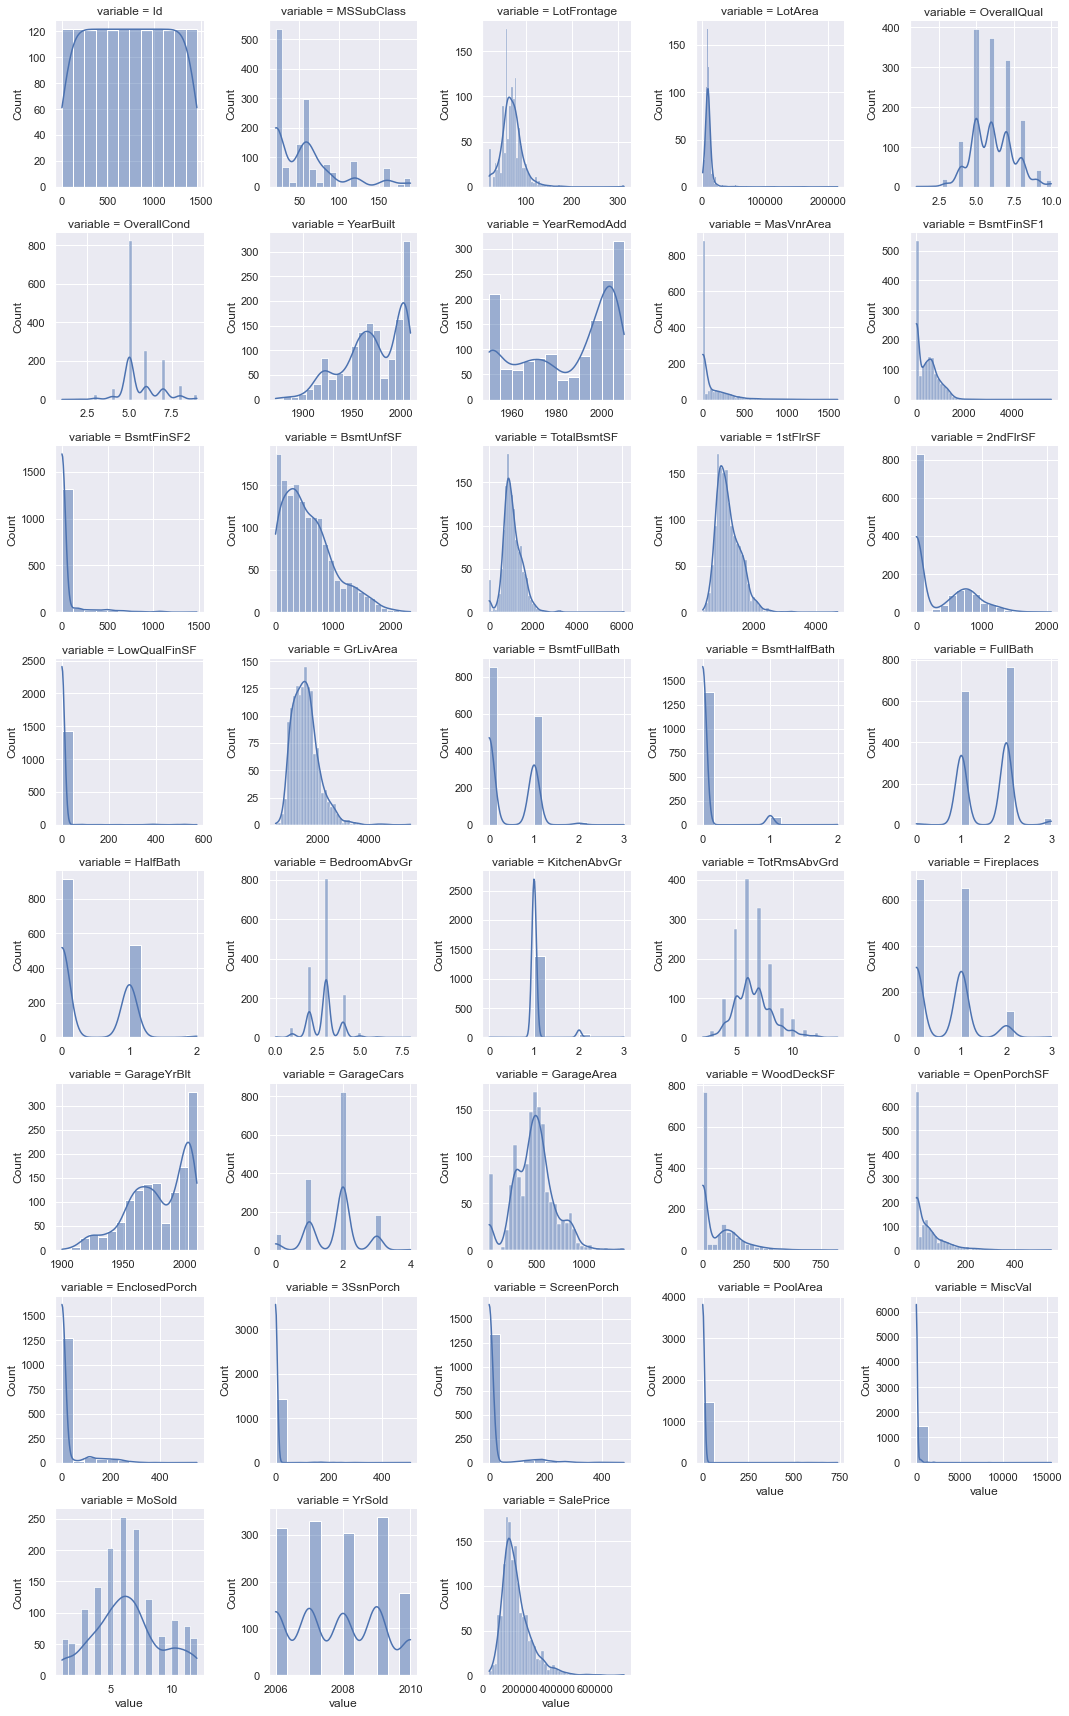

In [37]:
data = df_train.copy()
num_features=data.select_dtypes('number')
numerical_dist(data,num_features)

LotFrontage, LotArea, BsmtUnSF, TotalBsmtSF, 1stFlrSF, GrLivArea, GarageaRea tienen sesgo hacia la derecha

GarageYrBlt tienen sesgo hacia la izquierda

Hay variables sesgadas al 0

#### Bivariate

In [ ]:
def scatter_plots(df,var,num_features):
    f = pd.melt(df,id_vars=var,value_vars=num_features)
    g = sns.FacetGrid(f,col='variable', col_wrap= 5, sharex= False, sharey= False)
    g = g.map(sns.scatterplot,'value',var)

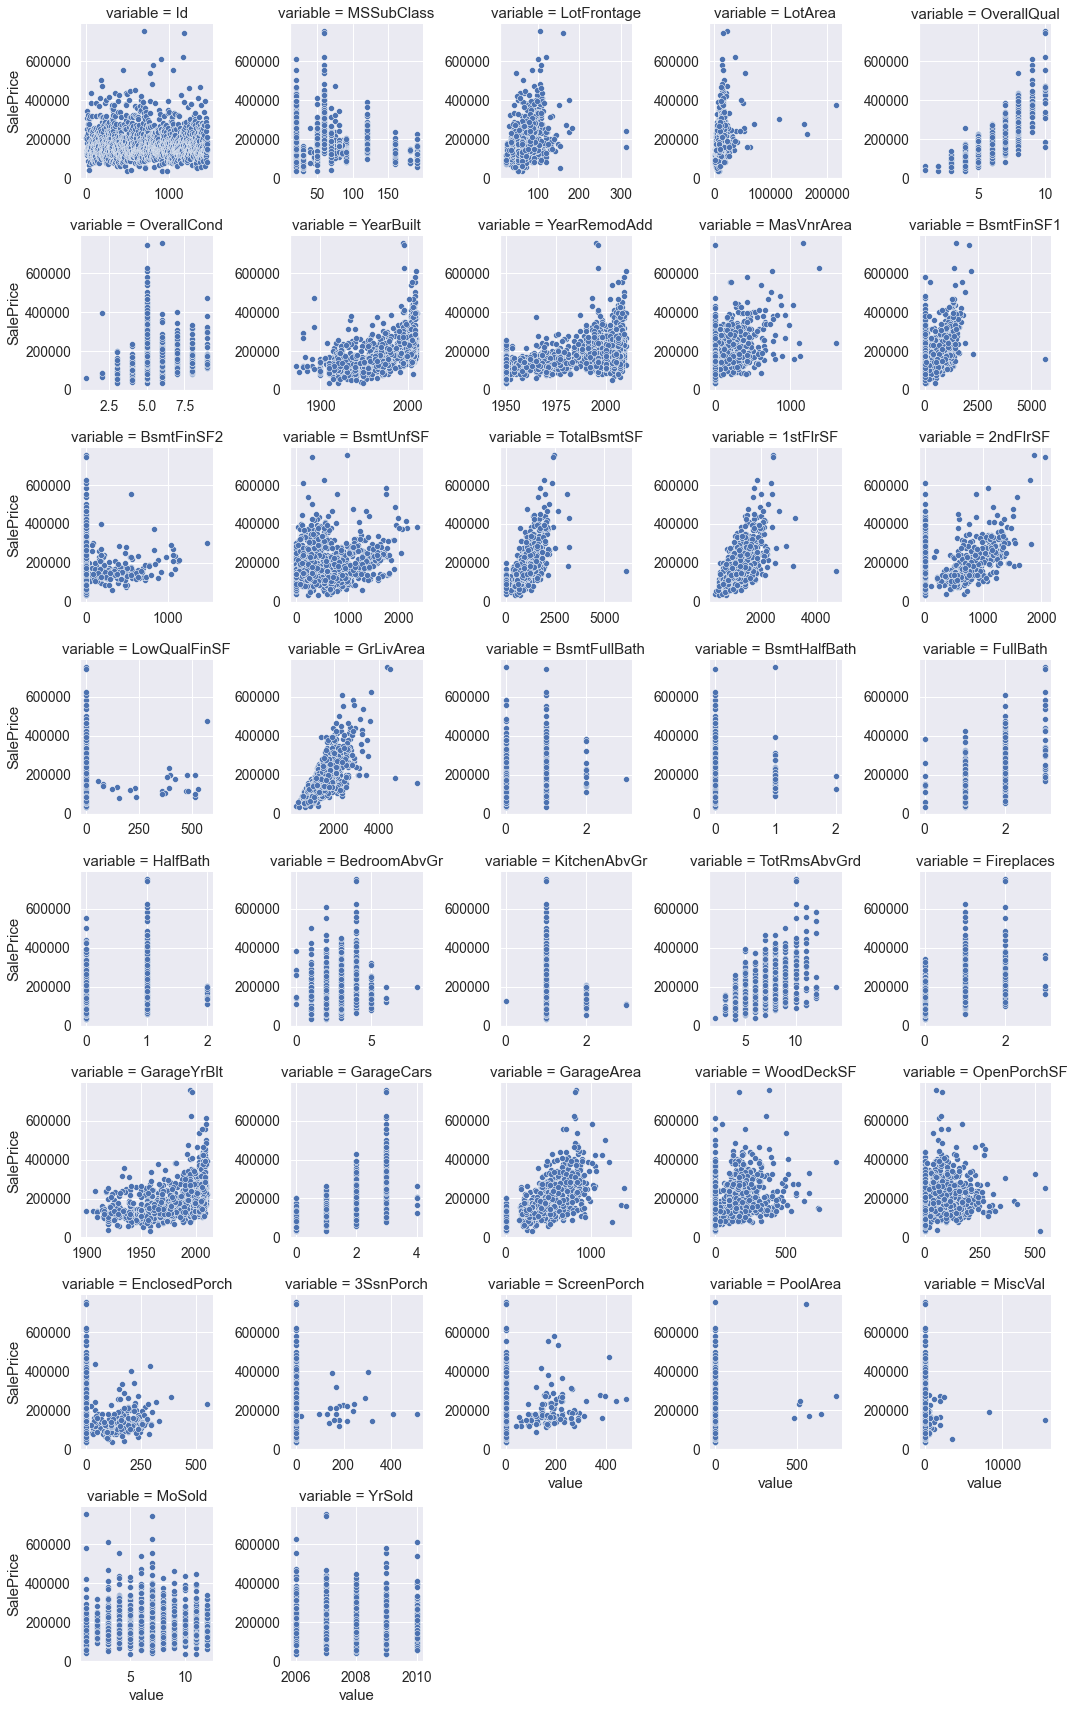

In [ ]:
scatter_plots(df_train,'SalePrice',num_features)

In [ ]:
num_features.describe()

Id   MSSubClass  ...       YrSold      SalePrice
count  1460.000000  1460.000000  ...  1460.000000    1460.000000
mean    730.500000    56.897260  ...  2007.815753  180921.195890
std     421.610009    42.300571  ...     1.328095   79442.502883
min       1.000000    20.000000  ...  2006.000000   34900.000000
25%     365.750000    20.000000  ...  2007.000000  129975.000000
50%     730.500000    50.000000  ...  2008.000000  163000.000000
75%    1095.250000    70.000000  ...  2009.000000  214000.000000
max    1460.000000   190.000000  ...  2010.000000  755000.000000

[8 rows x 38 columns]


buscar mas sobre linealidad y las transformaciones para lograrla, multicolinearidad, Durbin-watson test, tabla de frecuencia para las variables categoricas


It was also confirmed that some independent variables were correlated with each other. As expected, I visualized it as a scatter plot.
The high correlation between independent variables causes multicollinearity. The explanatory power of the model loses its reliability.
I decided to use regulation rather than choosing variables or using dimension reduction right away.
The linear model may solve the above problem through regulation (normal1, normal2).

It was difficult to visualize all variables, so I looked at the independent variables that required conversion through skewness and kurtosis. 
